In [552]:
!pip install catboost -q

In [669]:
# Import the libraries

import sys
import numpy as np
import pandas as pd
import optuna
import seaborn as sns
from catboost import CatBoostRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt


from sklearn.linear_model import Ridge
from sklearn.cross_decomposition import PLSRegression
from pandas.plotting import scatter_matrix
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use("ggplot")

np.random.seed(0)

In [612]:
# Load the data

train = pd.read_csv("./OneDrive/Documents/Ames+Regression/train.csv", index_col = "Id")
test = pd.read_csv("./OneDrive/Documents/Ames+Regression/test.csv", index_col = "Id")

price = train.SalePrice   
train.drop("SalePrice", axis = 1, inplace = True)

In [613]:
# Quick glance over data shows some missing values
train.sample(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
530,20,RL,NaN,32668,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,3,1957,1975,Hip,CompShg,Wd Sdng,Stone,NaN,NaN,Gd,TA,PConc,TA,TA,No,Rec,1219,Unf,0,816,2035,GasA,TA,Y,SBrkr,2515,0,0,2515,1,0,3,0,4,2,TA,9,Maj1,2,TA,Attchd,1975.0,RFn,2,484,TA,TA,Y,0,0,200,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Alloca
492,50,RL,79.0,9490,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Artery,Norm,1Fam,1.5Fin,6,7,1941,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,403,Rec,165,238,806,GasA,TA,Y,FuseA,958,620,0,1578,1,0,1,0,3,1,Fa,5,Typ,2,TA,Attchd,1941.0,Unf,1,240,TA,TA,Y,0,0,32,0,0,0,NaN,MnPrv,NaN,0,8,2006,WD,Normal
460,50,RL,NaN,7015,Pave,NaN,IR1,Bnk,AllPub,Corner,Gtl,BrkSide,Norm,Norm,1Fam,1.5Fin,5,4,1950,1950,Gable,CompShg,MetalSd,MetalSd,BrkCmn,161.0,TA,TA,CBlock,TA,TA,No,LwQ,185,Unf,0,524,709,GasA,TA,Y,SBrkr,979,224,0,1203,1,0,1,0,3,1,Gd,5,Typ,1,TA,Detchd,1950.0,Unf,1,352,TA,TA,Y,0,0,248,0,0,0,NaN,NaN,NaN,0,7,2009,WD,Normal
280,60,RL,83.0,10005,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,2Story,7,5,1977,1977,Hip,CompShg,Plywood,Plywood,BrkFace,299.0,TA,TA,CBlock,Gd,TA,No,BLQ,392,Unf,0,768,1160,GasA,Ex,Y,SBrkr,1156,866,0,2022,0,0,2,1,4,1,TA,8,Typ,1,TA,Attchd,1977.0,Fin,2,505,TA,TA,Y,288,117,0,0,0,0,NaN,NaN,NaN,0,3,2008,WD,Normal
656,160,RM,21.0,1680,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,Twnhs,2Story,6,5,1971,1971,Gable,CompShg,HdBoard,ImStucc,BrkFace,381.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,525,525,GasA,TA,Y,SBrkr,525,567,0,1092,0,0,1,1,3,1,TA,6,Typ,0,NaN,Detchd,1971.0,Unf,1,264,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,Family
1014,30,RM,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,4,1910,2006,Hip,CompShg,MetalSd,Stucco,None,0.0,TA,TA,BrkTil,TA,TA,No,ALQ,247,Rec,465,310,1022,GasW,TA,N,SBrkr,1022,0,0,1022,1,0,1,0,2,1,TA,4,Maj2,0,NaN,Detchd,1956.0,Unf,1,280,TA,TA,Y,0,30,226,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal
1404,20,RL,49.0,15256,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Somerst,RRAn,Norm,1Fam,1Story,8,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,Stone,84.0,Gd,TA,PConc,Gd,TA,Gd,GLQ,929,Unf,0,556,1485,GasA,Ex,Y,SBrkr,1464,0,0,1464,1,0,2,0,3,1,Gd,6,Typ,0,NaN,Attchd,2007.0,Unf,3,754,TA,TA,Y,168,160,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
602,50,RM,50.0,9000,Pave,NaN,Reg,Bnk,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1.5Fin,6,6,1937,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Gd,PConc,TA,TA,No,Unf,0,Unf,0,780,780,GasA,TA,Y,SBrkr,780,595,0,1375,0,0,1,1,3,1,Gd,6,Typ,1,Gd,Detchd,1979.0,Unf,1,544,TA,TA,P,0,162,0,0,126,0,NaN,NaN,NaN,0,12,2007,WD,Normal
1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml


In [614]:
print(f"Shape of the TRAIN set {train.shape}")
print(f"Shape of the TEST set {test.shape}")

Shape of the TRAIN set (1460, 79)
Shape of the TEST set (1459, 79)


### Exploratory Data Analysis

In [615]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


There are a few noteworthy statistics here. 
1. Lot area ranges between 1300 SF up to slightly higher than 215000 SF with a mean of 10517 SF.
2. The houses were built from 1872 to 2010.
3. The mean sale price is 180,921 USD while the median is 163,000 USD. 

Let's look further into the distribution of prices. 

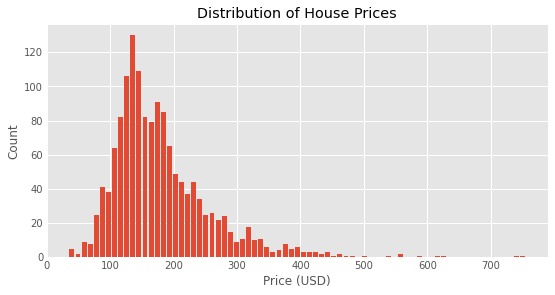

In [616]:
# What's the price range?

(train1.SalePrice/1000).hist(bins=75, rwidth=.8, figsize=(8,4))
plt.title('Distribution of House Prices')
plt.ylabel("Count")
plt.xlabel("Price (USD)")
plt.show()

Prices are apparantly skewed to the right. I will consider a log transformation to make them more Gaussian
The plot above and the barplot below suggest the existence of some outliers. 

Median: 163000.0


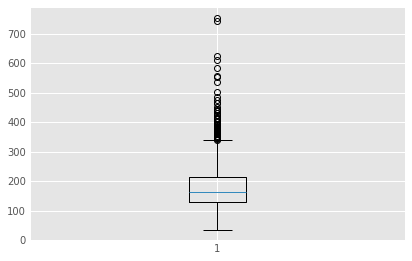

In [617]:
plt.boxplot(price/1000);
print("Median: {}".format(train1["SalePrice"].median()))

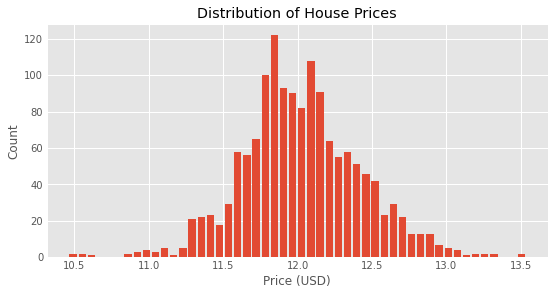

In [618]:
# Are log prices more Gaussian?

(np.log(train1.SalePrice)).hist(bins=50, rwidth=.8, figsize=(8,4))
plt.title('Distribution of House Prices')
plt.ylabel("Count")
plt.xlabel("Price (USD)")
plt.show()

The next question is "what are the most correlated features with the response variable?"

Based on the numbers below, it seems that overall quality and the living area above ground are very important. Some of the features can be combined in the top 10. For instance GarageCars and GarageArea are probably signaling the 
same thing. 

In [619]:
corr_with_price = train.corrwith(price).sort_values(ascending=False)
corr_with_price.head(10)

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
dtype: float64

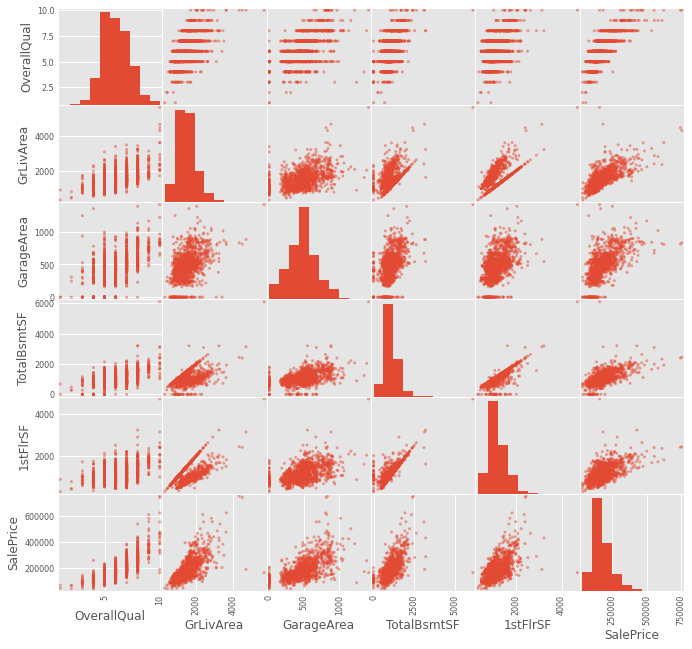

In [620]:
#Let's take a quick look at some of the features and how they are related to price. 

top_features = ["OverallQual", "GrLivArea", "GarageArea", "TotalBsmtSF", "1stFlrSF",'SalePrice']

scatter_matrix(train1[top_features], figsize=(10,10));

The year the house was built


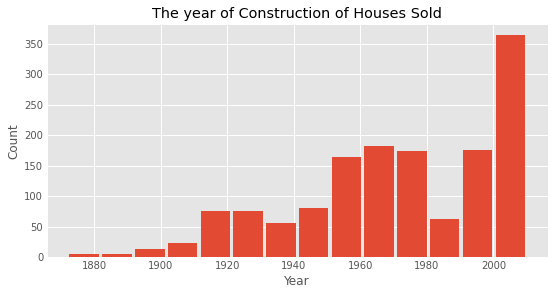

In [571]:
# When were the houses built?
print('The year the house was built'.format(
    train1.YearBuilt.min(), train1.YearBuilt.max()))
train1.YearBuilt.hist(bins=14, rwidth=.9, figsize=(8,4))
plt.title('The year of Construction of Houses Sold')
plt.ylabel("Count")
plt.xlabel("Year")
plt.show()

Looks like most houses the rate of construction has increased dramatticaly after 2000. 

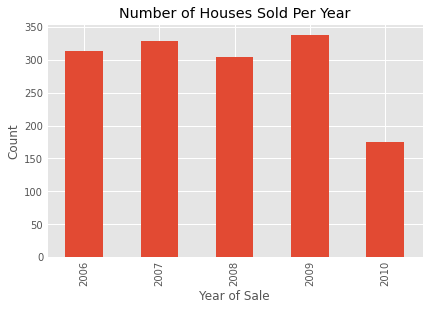

In [572]:
# When where houses sold?
train1.groupby(['YrSold']).SalePrice.count().plot(kind='bar', figsize=(6,4))
plt.title('Number of Houses Sold Per Year')
plt.ylabel("Count")
plt.xlabel("Year of Sale")
plt.show()

The above charts reveal certain surprises. In 2010, the number of houses sold dropped to less than half of the number in 2009. Otherwise, all the other years have a fairly similar number of houses sold. This could be due to the foreclosure crisis in 2010 when people put off selling their houses due to houses being forclosured in ther neighborhood leading to a reduction in prices.

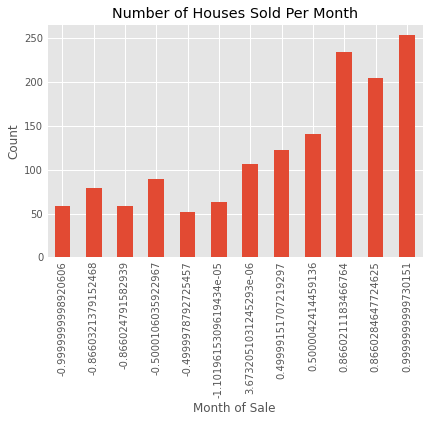

In [573]:
# When where houses sold?
train1.groupby(['MoSold']).SalePrice.count().plot(kind='bar', figsize=(6,4))
plt.title('Number of Houses Sold Per Month')
plt.ylabel("Count")
plt.xlabel("Month of Sale")
plt.show()

Not Surprisingly, market is hottest during summer. The month is indeed a period feature and I will model it by a cosine transformation. 

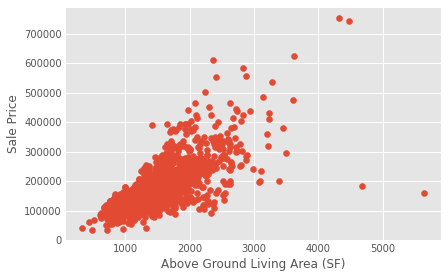

In [574]:
plt.scatter(train1['GrLivArea'], train1['SalePrice'])
plt.ylabel('Sale Price')
plt.xlabel('Above Ground Living Area (SF)')
plt.show()

Above Ground living area is positively correlated with price. This is intutive as people prefer more airy and 
bright above the ground areas. The next question is the price per SF.

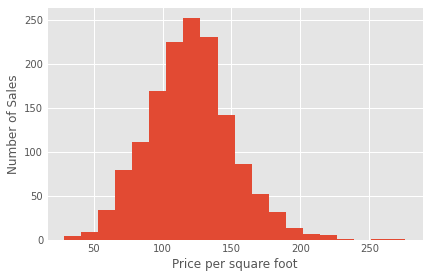

In [575]:
price_sf = train1['SalePrice']/train1['GrLivArea']
plt.hist(price_sf, bins=20)
plt.ylabel('Number of Sales')
plt.xlabel('Price per square foot')
plt.show()

In [576]:
print(price_sf.median())
print(price_sf.std())

120.09903146697134
31.391080743781764


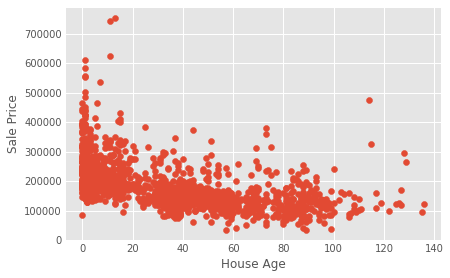

In [577]:
# Should I add a house age variable?

house_age = train['YrSold'] - train['YearBuilt']
plt.scatter(house_age, price)
plt.ylabel('Sale Price')
plt.xlabel('House Age')
plt.show()

Text(0.5, 0, 'Neighborhood')

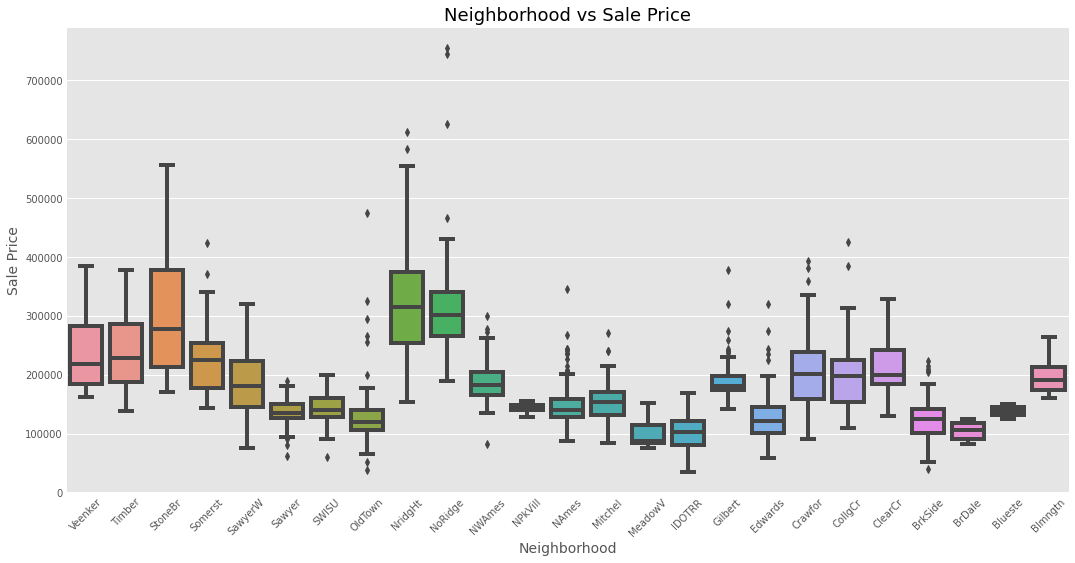

In [635]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=train, x=train['Neighborhood'].sort_values(ascending=False), y=price)
plt.xticks(rotation=45);
plt.title('Neighborhood vs Sale Price', fontsize=18)
plt.ylabel('Sale Price', fontsize=14)
plt.xlabel('Neighborhood', fontsize=14)

## Data Cleaning & Feature Engineering

Some features have a value of NA but that doesn't mean a missing value! For example for the feature "Fence", NA 
really means that the property doesn't have a fence. We need to correct this issue. For the ease of processing we can 
first concatanate the train and test sets.

In [578]:
# Drop the duplicates
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

train.isna().sum().sum()
test.isna().sum().sum()


# Correcting the type for MSSubClass
train['MSSubClass'] = train0['MSSubClass'].astype(str)
test['MSSubClass'] = test['MSSubClass'].astype(str)


# Cyclical Transformation of MoSold
train["MoSold"] = -np.cos(0.5236 * train1["MoSold"])
test["MoSold"] = -np.cos(0.5236 * test["MoSold"])

In [579]:
# Change using a constant value None. For these columns NA actually means the feature 
# doesn't exist
for column in [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]:
    train[column] = train[column].fillna("None")
    test[column] = test[column].fillna("None")

In [580]:
# Impute using the column mode

categories = [
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
]

for column in categories:
    train[column] = train[column].fillna(train[column].mode()[0])
    test[column] = test[column].fillna(test[column].mode()[0])

In [581]:
# Creating New Features

def feature_engineer(df):
    df['totalSqFeet'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['totalBathroom'] = df.FullBath + df.BsmtFullBath + 0.5 * (df.HalfBath + df.BsmtHalfBath)
    df['houseAge'] = df.YrSold - df.YearBuilt
    df['reModeled'] = np.where(df.YearRemodAdd == df.YearBuilt, 0, 1)
    df['isNew'] = np.where(df.YrSold == df.YearBuilt, 1, 0)
    
train_fe = train.copy() 
test_fe = test.copy()

feature_engineer(train_fe)
feature_engineer(test_fe)

In [ ]:
train.info()

In [583]:
# Create a data processing pipeline

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

numeric_transformer = Pipeline([("imputer", KNNImputer(n_neighbors=4)), 
                         ("scaler", StandardScaler())]
                       )
categorical_transformer = Pipeline(
    [
        ("ohe", OneHotEncoder(handle_unknown="ignore")), 
        ("imputer", SimpleImputer(strategy='most_frequent'))
                                       ]
                         )

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="object")),
        ("cat", categorical_transformer, selector(dtype_include="object")),
    ]
)


In [622]:
train_fe.shape

(1460, 84)

## Modeling 

#### 1. Linear Model  
At ehe first step I start with a linear model, namely ridge regression and train it on "train" data meaning the data set without any feature engineering. I also don't log-scale the target value. To that end, I performed a 5-fold cross-validation on the train data and changed the regularization parameter from 0.1 (close to no regularization) all the way to 100 (strong regularization)

In [ ]:
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", Ridge(random_state=1))]
)

param_grid = {"regressor__alpha" : [0.1, 1, 10, 100]}

grid_search = GridSearchCV(pipe, param_grid, cv=5,
scoring='neg_root_mean_squared_error',
return_train_score=True);

grid_search.fit(train, price)

In [655]:
ridge_rmse_train_no_log = -grid_search.best_score_  ## the rmse is very high 

# Output: 31104.55

31104.558204213885

In [647]:
ridge_alpha_train_no_log = grid_search.best_params_

# Output: 10 

{'regressor__alpha': 10}

I learned that first of all I should try log transform on target. Second, regularization helps 
because the best value picked for alpha is apparantly much larger than 0. 

In [657]:
# log transformation of target. 

log_price = np.log(price)
grid_search.fit(train, log_price);

In [659]:
ridge_rmse_train_log = np.exp(-grid_search.best_score_)
print(f'Best RMSE: {np.exp(-grid_search.best_score_):9.5f}')

# Output: Best RMSE: 1.14943

Best RMSE:   1.14943


In [662]:
# Ridge regression on training set with extra features 

grid_search.fit(train_fe, log_price);
ridge_rmse_train_fe_log = np.exp(-grid_search.best_score_)
print(f'Best RMSE: {ridge_rmse_train_fe_log:1.5f}')

# Output: Best RMSE: 1.14908

Best RMSE: 1.14908


We see a very slight improvement when we use the training data with extra features. Let's stick with this data set from now on.

In [667]:
# convinience function to create submission files. 

def create_submission(suffix):
    price_hat = pd.DataFrame(np.exp(grid_search.predict(test_fe)))  
    price_hat["Id"] = test.index
    price_hat.columns = ["SalePrice", "Id"]
    submission = price_hat.reindex(columns=["Id", "SalePrice"])
    submission.to_csv(f"submission_{suffix}.csv", header=True, index = False)
create_submission("ridge")

### Sparsity

In [ ]:
# Let's explore wether sparsity would improve rmse 

pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", Lasso(random_state=1))]
)

param_grid = {"regressor__alpha" : [0.1, 1, 10, 100]}

grid_search = GridSearchCV(pipe, param_grid, cv=5,
scoring='neg_root_mean_squared_error',
return_train_score=True);

grid_search.fit(train_fe, log_price)

In [676]:
lasso_rmse_train_fe_log = np.exp(-grid_search.best_score_)  ## the rmse is very high 
print(f'Best RMSE: {lasso_rmse_train_fe_log:1.5f}')
# Output: 1.23760

Best RMSE: 1.23760


The result has improved compared to ridge regression. 

In [677]:
create_submission("lasso")

In [689]:
# Let's look at the features picked by lasso.

df = pd.DataFrame(zip(train_fe.columns, 
                 list(grid_search.best_estimator_.named_steps.regressor.coef_)
                ))
df.columns = ["Feature", "Coefficient"]

df[df.Coefficient > 0]

,Feature,Coefficient
2,LotFrontage,0.134380
24,MasVnrType,0.030592
35,BsmtFinSF2,0.086787
36,BsmtUnfSF,0.028794


### Random Forest -- Dealing with non-linearity

In [690]:
# This can take about 10 minutes!

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", RandomForestRegressor())]
)

param_grid = { 
    'regressor__n_estimators': [100, 200, 500],
    'regressor__max_depth' : [4,5,6,7,8], 
    'regressor__min_samples_split' : [2, 4, 6]
}

grid_search = GridSearchCV(clf, param_grid, cv=5,
scoring='neg_root_mean_squared_error',
return_train_score=True, verbose=0);

grid_search.fit(train_fe, log_price)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer(n_neighbors=4)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001AEF0551C90>),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                           

In [694]:
rf_rmse_train_fe_log = np.exp(-grid_search.best_score_)
print(f'RMSE: {rf_rmse_train_fe_log:1.5f}')

# Output RMSE: 1.15484

RMSE: 1.15484


The score has improved compared to  both lasso and ridge regression.

In [695]:
grid_search.best_params_

{'regressor__max_depth': 8,
 'regressor__min_samples_split': 2,
 'regressor__n_estimators': 100}

In [642]:
print(f'RMSE: {np.exp(-grid_search.best_score_):1.5f}')

RMSE: 1.15497


In [644]:
grid_search.best_params_

{'regressor__max_depth': 8,
 'regressor__min_samples_split': 4,
 'regressor__n_estimators': 500}

In [696]:
create_submission("rf")

In [ ]:
#Kaggle Score: 0.14627

My Kaggle Score dramattically decreased from 0.25 for Ridge, to 0.21 for lasso and to 0.14 I used RF. This is indicative
of non-linearity in the data. 

In [698]:
# This can take about 10 minutes!

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", CatBoostRegressor())]
)

param_grid = { 
    'regressor__n_estimators': [100, 200, 500],
    'regressor__max_depth' : [4, 6, 8]
}

grid_search = GridSearchCV(clf, param_grid, cv=5,
scoring='neg_root_mean_squared_error',
return_train_score=True, verbose=1);

grid_search.fit(train_fe, log_price)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Learning rate set to 0.272794
0:	learn: 0.3444529	total: 2.8ms	remaining: 277ms
1:	learn: 0.2973240	total: 5.24ms	remaining: 257ms
2:	learn: 0.2587806	total: 7.64ms	remaining: 247ms
3:	learn: 0.2294938	total: 10.1ms	remaining: 241ms
4:	learn: 0.2066372	total: 12.5ms	remaining: 237ms
5:	learn: 0.1915996	total: 14.8ms	remaining: 232ms
6:	learn: 0.1787474	total: 17.3ms	remaining: 230ms
7:	learn: 0.1677303	total: 20.1ms	remaining: 231ms
8:	learn: 0.1598668	total: 22.4ms	remaining: 226ms
9:	learn: 0.1533880	total: 24.6ms	remaining: 221ms
10:	learn: 0.1481909	total: 27ms	remaining: 218ms
11:	learn: 0.1446032	total: 29.2ms	remaining: 214ms
12:	learn: 0.1412559	total: 31.5ms	remaining: 211ms
13:	learn: 0.1379566	total: 33.8ms	remaining: 208ms
14:	learn: 0.1353591	total: 36.1ms	remaining: 205ms
15:	learn: 0.1325883	total: 38.5ms	remaining: 202ms
16:	learn: 0.1304052	total: 40.5ms	remaining: 198ms
17:	learn: 0.1284549	total: 43.7ms	rema

73:	learn: 0.0822510	total: 172ms	remaining: 60.4ms
74:	learn: 0.0817990	total: 175ms	remaining: 58.2ms
75:	learn: 0.0811906	total: 177ms	remaining: 56ms
76:	learn: 0.0807212	total: 182ms	remaining: 54.3ms
77:	learn: 0.0802785	total: 185ms	remaining: 52.2ms
78:	learn: 0.0801569	total: 188ms	remaining: 49.9ms
79:	learn: 0.0795901	total: 192ms	remaining: 47.9ms
80:	learn: 0.0791350	total: 195ms	remaining: 45.7ms
81:	learn: 0.0786018	total: 197ms	remaining: 43.3ms
82:	learn: 0.0778088	total: 200ms	remaining: 40.9ms
83:	learn: 0.0773635	total: 202ms	remaining: 38.5ms
84:	learn: 0.0772350	total: 204ms	remaining: 36.1ms
85:	learn: 0.0767698	total: 208ms	remaining: 33.8ms
86:	learn: 0.0762765	total: 210ms	remaining: 31.3ms
87:	learn: 0.0756200	total: 212ms	remaining: 28.9ms
88:	learn: 0.0753351	total: 214ms	remaining: 26.5ms
89:	learn: 0.0746468	total: 217ms	remaining: 24.1ms
90:	learn: 0.0742836	total: 220ms	remaining: 21.7ms
91:	learn: 0.0739651	total: 222ms	remaining: 19.3ms
92:	learn: 0.0

67:	learn: 0.0856812	total: 165ms	remaining: 77.7ms
68:	learn: 0.0855212	total: 168ms	remaining: 75.7ms
69:	learn: 0.0846791	total: 171ms	remaining: 73.4ms
70:	learn: 0.0845250	total: 174ms	remaining: 71.1ms
71:	learn: 0.0842550	total: 177ms	remaining: 68.7ms
72:	learn: 0.0839268	total: 179ms	remaining: 66.2ms
73:	learn: 0.0834034	total: 181ms	remaining: 63.7ms
74:	learn: 0.0829817	total: 184ms	remaining: 61.3ms
75:	learn: 0.0826881	total: 186ms	remaining: 58.7ms
76:	learn: 0.0820505	total: 188ms	remaining: 56.2ms
77:	learn: 0.0818336	total: 190ms	remaining: 53.7ms
78:	learn: 0.0813590	total: 192ms	remaining: 51.1ms
79:	learn: 0.0807508	total: 194ms	remaining: 48.5ms
80:	learn: 0.0803608	total: 196ms	remaining: 45.9ms
81:	learn: 0.0795966	total: 199ms	remaining: 43.6ms
82:	learn: 0.0795040	total: 200ms	remaining: 41.1ms
83:	learn: 0.0793102	total: 202ms	remaining: 38.5ms
84:	learn: 0.0787901	total: 204ms	remaining: 36ms
85:	learn: 0.0783807	total: 206ms	remaining: 33.5ms
86:	learn: 0.0

83:	learn: 0.0950243	total: 168ms	remaining: 232ms
84:	learn: 0.0945964	total: 170ms	remaining: 230ms
85:	learn: 0.0941031	total: 172ms	remaining: 228ms
86:	learn: 0.0940384	total: 174ms	remaining: 227ms
87:	learn: 0.0936605	total: 177ms	remaining: 225ms
88:	learn: 0.0932283	total: 180ms	remaining: 224ms
89:	learn: 0.0928388	total: 182ms	remaining: 222ms
90:	learn: 0.0923993	total: 184ms	remaining: 220ms
91:	learn: 0.0921691	total: 185ms	remaining: 218ms
92:	learn: 0.0917917	total: 187ms	remaining: 216ms
93:	learn: 0.0914232	total: 189ms	remaining: 213ms
94:	learn: 0.0910630	total: 191ms	remaining: 211ms
95:	learn: 0.0909190	total: 193ms	remaining: 210ms
96:	learn: 0.0905577	total: 195ms	remaining: 207ms
97:	learn: 0.0902779	total: 197ms	remaining: 205ms
98:	learn: 0.0898849	total: 199ms	remaining: 203ms
99:	learn: 0.0893855	total: 201ms	remaining: 201ms
100:	learn: 0.0890383	total: 203ms	remaining: 199ms
101:	learn: 0.0886904	total: 205ms	remaining: 197ms
102:	learn: 0.0884785	total: 

86:	learn: 0.0917507	total: 169ms	remaining: 220ms
87:	learn: 0.0912870	total: 171ms	remaining: 218ms
88:	learn: 0.0911950	total: 173ms	remaining: 216ms
89:	learn: 0.0907390	total: 175ms	remaining: 214ms
90:	learn: 0.0905749	total: 178ms	remaining: 213ms
91:	learn: 0.0904224	total: 181ms	remaining: 212ms
92:	learn: 0.0901099	total: 183ms	remaining: 210ms
93:	learn: 0.0900524	total: 184ms	remaining: 208ms
94:	learn: 0.0896025	total: 186ms	remaining: 206ms
95:	learn: 0.0892677	total: 188ms	remaining: 204ms
96:	learn: 0.0888003	total: 190ms	remaining: 202ms
97:	learn: 0.0886890	total: 192ms	remaining: 199ms
98:	learn: 0.0883636	total: 193ms	remaining: 197ms
99:	learn: 0.0879008	total: 195ms	remaining: 195ms
100:	learn: 0.0875524	total: 197ms	remaining: 194ms
101:	learn: 0.0871675	total: 199ms	remaining: 191ms
102:	learn: 0.0869171	total: 201ms	remaining: 189ms
103:	learn: 0.0866094	total: 203ms	remaining: 187ms
104:	learn: 0.0863152	total: 205ms	remaining: 185ms
105:	learn: 0.0862468	tota

84:	learn: 0.0888996	total: 169ms	remaining: 229ms
85:	learn: 0.0885259	total: 171ms	remaining: 227ms
86:	learn: 0.0881527	total: 173ms	remaining: 225ms
87:	learn: 0.0876614	total: 176ms	remaining: 224ms
88:	learn: 0.0872552	total: 178ms	remaining: 222ms
89:	learn: 0.0868124	total: 180ms	remaining: 220ms
90:	learn: 0.0865849	total: 182ms	remaining: 218ms
91:	learn: 0.0861656	total: 185ms	remaining: 217ms
92:	learn: 0.0857755	total: 187ms	remaining: 215ms
93:	learn: 0.0853807	total: 189ms	remaining: 213ms
94:	learn: 0.0849289	total: 191ms	remaining: 211ms
95:	learn: 0.0845094	total: 192ms	remaining: 209ms
96:	learn: 0.0842425	total: 194ms	remaining: 206ms
97:	learn: 0.0839018	total: 196ms	remaining: 204ms
98:	learn: 0.0835878	total: 198ms	remaining: 202ms
99:	learn: 0.0832074	total: 200ms	remaining: 200ms
100:	learn: 0.0828718	total: 202ms	remaining: 198ms
101:	learn: 0.0824758	total: 204ms	remaining: 196ms
102:	learn: 0.0822458	total: 206ms	remaining: 194ms
103:	learn: 0.0819309	total:

88:	learn: 0.0934118	total: 174ms	remaining: 217ms
89:	learn: 0.0929421	total: 176ms	remaining: 215ms
90:	learn: 0.0925312	total: 178ms	remaining: 213ms
91:	learn: 0.0920026	total: 181ms	remaining: 212ms
92:	learn: 0.0917279	total: 183ms	remaining: 210ms
93:	learn: 0.0916149	total: 185ms	remaining: 209ms
94:	learn: 0.0915222	total: 188ms	remaining: 207ms
95:	learn: 0.0912012	total: 189ms	remaining: 205ms
96:	learn: 0.0909327	total: 191ms	remaining: 203ms
97:	learn: 0.0905032	total: 193ms	remaining: 201ms
98:	learn: 0.0901820	total: 195ms	remaining: 199ms
99:	learn: 0.0898784	total: 197ms	remaining: 197ms
100:	learn: 0.0897812	total: 198ms	remaining: 194ms
101:	learn: 0.0893818	total: 200ms	remaining: 192ms
102:	learn: 0.0890516	total: 202ms	remaining: 190ms
103:	learn: 0.0889909	total: 204ms	remaining: 188ms
104:	learn: 0.0883862	total: 206ms	remaining: 186ms
105:	learn: 0.0879171	total: 207ms	remaining: 184ms
106:	learn: 0.0876933	total: 209ms	remaining: 182ms
107:	learn: 0.0874239	to

86:	learn: 0.0905120	total: 171ms	remaining: 222ms
87:	learn: 0.0900617	total: 174ms	remaining: 221ms
88:	learn: 0.0896275	total: 176ms	remaining: 219ms
89:	learn: 0.0892894	total: 178ms	remaining: 218ms
90:	learn: 0.0889084	total: 181ms	remaining: 217ms
91:	learn: 0.0888360	total: 187ms	remaining: 220ms
92:	learn: 0.0884251	total: 189ms	remaining: 218ms
93:	learn: 0.0880647	total: 191ms	remaining: 216ms
94:	learn: 0.0878022	total: 193ms	remaining: 214ms
95:	learn: 0.0876114	total: 195ms	remaining: 211ms
96:	learn: 0.0872340	total: 197ms	remaining: 209ms
97:	learn: 0.0870032	total: 199ms	remaining: 207ms
98:	learn: 0.0866083	total: 201ms	remaining: 205ms
99:	learn: 0.0865358	total: 203ms	remaining: 203ms
100:	learn: 0.0864481	total: 204ms	remaining: 200ms
101:	learn: 0.0863036	total: 206ms	remaining: 198ms
102:	learn: 0.0859215	total: 208ms	remaining: 196ms
103:	learn: 0.0854822	total: 210ms	remaining: 193ms
104:	learn: 0.0852211	total: 211ms	remaining: 191ms
105:	learn: 0.0851544	tota

82:	learn: 0.1177135	total: 165ms	remaining: 827ms
83:	learn: 0.1173660	total: 167ms	remaining: 827ms
84:	learn: 0.1169511	total: 169ms	remaining: 826ms
85:	learn: 0.1163489	total: 171ms	remaining: 825ms
86:	learn: 0.1157531	total: 174ms	remaining: 824ms
87:	learn: 0.1152922	total: 176ms	remaining: 823ms
88:	learn: 0.1149021	total: 178ms	remaining: 820ms
89:	learn: 0.1147328	total: 179ms	remaining: 818ms
90:	learn: 0.1142835	total: 181ms	remaining: 815ms
91:	learn: 0.1137948	total: 184ms	remaining: 815ms
92:	learn: 0.1133920	total: 186ms	remaining: 812ms
93:	learn: 0.1131380	total: 187ms	remaining: 809ms
94:	learn: 0.1127568	total: 189ms	remaining: 807ms
95:	learn: 0.1123058	total: 191ms	remaining: 805ms
96:	learn: 0.1122032	total: 194ms	remaining: 804ms
97:	learn: 0.1119262	total: 196ms	remaining: 803ms
98:	learn: 0.1116377	total: 198ms	remaining: 804ms
99:	learn: 0.1112875	total: 201ms	remaining: 803ms
100:	learn: 0.1110039	total: 203ms	remaining: 802ms
101:	learn: 0.1106240	total: 2

269:	learn: 0.0796796	total: 518ms	remaining: 442ms
270:	learn: 0.0795780	total: 520ms	remaining: 440ms
271:	learn: 0.0794925	total: 522ms	remaining: 438ms
272:	learn: 0.0793643	total: 524ms	remaining: 436ms
273:	learn: 0.0792287	total: 526ms	remaining: 434ms
274:	learn: 0.0791312	total: 528ms	remaining: 432ms
275:	learn: 0.0790630	total: 530ms	remaining: 430ms
276:	learn: 0.0789712	total: 532ms	remaining: 428ms
277:	learn: 0.0788598	total: 534ms	remaining: 426ms
278:	learn: 0.0788052	total: 536ms	remaining: 425ms
279:	learn: 0.0787596	total: 539ms	remaining: 423ms
280:	learn: 0.0785511	total: 541ms	remaining: 421ms
281:	learn: 0.0785116	total: 543ms	remaining: 420ms
282:	learn: 0.0784243	total: 545ms	remaining: 418ms
283:	learn: 0.0783456	total: 547ms	remaining: 416ms
284:	learn: 0.0783236	total: 549ms	remaining: 414ms
285:	learn: 0.0782292	total: 551ms	remaining: 412ms
286:	learn: 0.0780836	total: 552ms	remaining: 410ms
287:	learn: 0.0779661	total: 554ms	remaining: 408ms
288:	learn: 

456:	learn: 0.0639715	total: 870ms	remaining: 81.9ms
457:	learn: 0.0638581	total: 873ms	remaining: 80ms
458:	learn: 0.0638001	total: 875ms	remaining: 78.2ms
459:	learn: 0.0637909	total: 877ms	remaining: 76.3ms
460:	learn: 0.0637485	total: 879ms	remaining: 74.4ms
461:	learn: 0.0636890	total: 881ms	remaining: 72.5ms
462:	learn: 0.0636784	total: 883ms	remaining: 70.6ms
463:	learn: 0.0636317	total: 885ms	remaining: 68.7ms
464:	learn: 0.0636187	total: 887ms	remaining: 66.7ms
465:	learn: 0.0635760	total: 889ms	remaining: 64.8ms
466:	learn: 0.0635288	total: 891ms	remaining: 63ms
467:	learn: 0.0634469	total: 893ms	remaining: 61ms
468:	learn: 0.0633885	total: 895ms	remaining: 59.1ms
469:	learn: 0.0632841	total: 897ms	remaining: 57.2ms
470:	learn: 0.0631814	total: 898ms	remaining: 55.3ms
471:	learn: 0.0631308	total: 900ms	remaining: 53.4ms
472:	learn: 0.0631225	total: 902ms	remaining: 51.5ms
473:	learn: 0.0631172	total: 904ms	remaining: 49.6ms
474:	learn: 0.0630158	total: 906ms	remaining: 47.7ms

185:	learn: 0.0899044	total: 355ms	remaining: 599ms
186:	learn: 0.0897175	total: 357ms	remaining: 597ms
187:	learn: 0.0895187	total: 359ms	remaining: 596ms
188:	learn: 0.0893437	total: 361ms	remaining: 595ms
189:	learn: 0.0892177	total: 364ms	remaining: 593ms
190:	learn: 0.0890426	total: 366ms	remaining: 592ms
191:	learn: 0.0888960	total: 368ms	remaining: 590ms
192:	learn: 0.0887378	total: 370ms	remaining: 589ms
193:	learn: 0.0886827	total: 373ms	remaining: 588ms
194:	learn: 0.0885040	total: 375ms	remaining: 587ms
195:	learn: 0.0884544	total: 377ms	remaining: 585ms
196:	learn: 0.0883528	total: 379ms	remaining: 583ms
197:	learn: 0.0883096	total: 381ms	remaining: 581ms
198:	learn: 0.0882159	total: 382ms	remaining: 578ms
199:	learn: 0.0881714	total: 384ms	remaining: 576ms
200:	learn: 0.0880386	total: 386ms	remaining: 574ms
201:	learn: 0.0878428	total: 388ms	remaining: 572ms
202:	learn: 0.0876613	total: 390ms	remaining: 571ms
203:	learn: 0.0874266	total: 392ms	remaining: 569ms
204:	learn: 

373:	learn: 0.0689447	total: 707ms	remaining: 238ms
374:	learn: 0.0688347	total: 709ms	remaining: 236ms
375:	learn: 0.0687454	total: 711ms	remaining: 235ms
376:	learn: 0.0686897	total: 714ms	remaining: 233ms
377:	learn: 0.0686553	total: 717ms	remaining: 231ms
378:	learn: 0.0685305	total: 720ms	remaining: 230ms
379:	learn: 0.0684622	total: 722ms	remaining: 228ms
380:	learn: 0.0683489	total: 724ms	remaining: 226ms
381:	learn: 0.0682406	total: 726ms	remaining: 224ms
382:	learn: 0.0681940	total: 728ms	remaining: 222ms
383:	learn: 0.0681468	total: 730ms	remaining: 220ms
384:	learn: 0.0681207	total: 731ms	remaining: 218ms
385:	learn: 0.0679973	total: 733ms	remaining: 217ms
386:	learn: 0.0679495	total: 736ms	remaining: 215ms
387:	learn: 0.0678785	total: 738ms	remaining: 213ms
388:	learn: 0.0677074	total: 740ms	remaining: 211ms
389:	learn: 0.0676765	total: 741ms	remaining: 209ms
390:	learn: 0.0676055	total: 743ms	remaining: 207ms
391:	learn: 0.0674988	total: 745ms	remaining: 205ms
392:	learn: 

83:	learn: 0.1135529	total: 170ms	remaining: 844ms
84:	learn: 0.1130402	total: 173ms	remaining: 843ms
85:	learn: 0.1127407	total: 175ms	remaining: 841ms
86:	learn: 0.1123340	total: 177ms	remaining: 839ms
87:	learn: 0.1118311	total: 179ms	remaining: 838ms
88:	learn: 0.1112980	total: 182ms	remaining: 839ms
89:	learn: 0.1111371	total: 184ms	remaining: 838ms
90:	learn: 0.1106227	total: 186ms	remaining: 837ms
91:	learn: 0.1101059	total: 188ms	remaining: 836ms
92:	learn: 0.1097005	total: 190ms	remaining: 833ms
93:	learn: 0.1093604	total: 192ms	remaining: 830ms
94:	learn: 0.1090965	total: 194ms	remaining: 826ms
95:	learn: 0.1086719	total: 196ms	remaining: 823ms
96:	learn: 0.1082221	total: 198ms	remaining: 822ms
97:	learn: 0.1078920	total: 200ms	remaining: 820ms
98:	learn: 0.1075111	total: 202ms	remaining: 817ms
99:	learn: 0.1071458	total: 204ms	remaining: 814ms
100:	learn: 0.1069379	total: 205ms	remaining: 811ms
101:	learn: 0.1065390	total: 207ms	remaining: 808ms
102:	learn: 0.1061982	total: 

271:	learn: 0.0763831	total: 524ms	remaining: 439ms
272:	learn: 0.0762743	total: 526ms	remaining: 438ms
273:	learn: 0.0761629	total: 529ms	remaining: 436ms
274:	learn: 0.0760589	total: 531ms	remaining: 434ms
275:	learn: 0.0759078	total: 533ms	remaining: 433ms
276:	learn: 0.0758017	total: 535ms	remaining: 431ms
277:	learn: 0.0756789	total: 537ms	remaining: 429ms
278:	learn: 0.0755298	total: 539ms	remaining: 427ms
279:	learn: 0.0753933	total: 541ms	remaining: 425ms
280:	learn: 0.0753460	total: 543ms	remaining: 423ms
281:	learn: 0.0752332	total: 545ms	remaining: 421ms
282:	learn: 0.0751469	total: 547ms	remaining: 419ms
283:	learn: 0.0751178	total: 549ms	remaining: 417ms
284:	learn: 0.0750647	total: 551ms	remaining: 415ms
285:	learn: 0.0750346	total: 552ms	remaining: 413ms
286:	learn: 0.0748825	total: 554ms	remaining: 411ms
287:	learn: 0.0748026	total: 556ms	remaining: 409ms
288:	learn: 0.0747190	total: 558ms	remaining: 407ms
289:	learn: 0.0745935	total: 560ms	remaining: 405ms
290:	learn: 

463:	learn: 0.0601607	total: 879ms	remaining: 68.2ms
464:	learn: 0.0600679	total: 882ms	remaining: 66.4ms
465:	learn: 0.0600339	total: 884ms	remaining: 64.5ms
466:	learn: 0.0599414	total: 886ms	remaining: 62.6ms
467:	learn: 0.0598339	total: 888ms	remaining: 60.7ms
468:	learn: 0.0597281	total: 891ms	remaining: 58.9ms
469:	learn: 0.0596747	total: 893ms	remaining: 57ms
470:	learn: 0.0596434	total: 895ms	remaining: 55.1ms
471:	learn: 0.0596260	total: 897ms	remaining: 53.2ms
472:	learn: 0.0595530	total: 899ms	remaining: 51.3ms
473:	learn: 0.0595089	total: 901ms	remaining: 49.4ms
474:	learn: 0.0594870	total: 903ms	remaining: 47.5ms
475:	learn: 0.0594347	total: 905ms	remaining: 45.6ms
476:	learn: 0.0593246	total: 907ms	remaining: 43.7ms
477:	learn: 0.0592551	total: 909ms	remaining: 41.9ms
478:	learn: 0.0592295	total: 911ms	remaining: 40ms
479:	learn: 0.0592058	total: 913ms	remaining: 38ms
480:	learn: 0.0590823	total: 915ms	remaining: 36.2ms
481:	learn: 0.0589949	total: 917ms	remaining: 34.3ms

182:	learn: 0.0911204	total: 353ms	remaining: 612ms
183:	learn: 0.0909689	total: 356ms	remaining: 611ms
184:	learn: 0.0907957	total: 358ms	remaining: 609ms
185:	learn: 0.0907355	total: 360ms	remaining: 607ms
186:	learn: 0.0904499	total: 362ms	remaining: 606ms
187:	learn: 0.0902252	total: 364ms	remaining: 604ms
188:	learn: 0.0900468	total: 366ms	remaining: 602ms
189:	learn: 0.0898695	total: 368ms	remaining: 600ms
190:	learn: 0.0897242	total: 370ms	remaining: 598ms
191:	learn: 0.0896141	total: 371ms	remaining: 596ms
192:	learn: 0.0894915	total: 374ms	remaining: 594ms
193:	learn: 0.0893366	total: 376ms	remaining: 592ms
194:	learn: 0.0892984	total: 377ms	remaining: 590ms
195:	learn: 0.0891174	total: 379ms	remaining: 588ms
196:	learn: 0.0890778	total: 381ms	remaining: 586ms
197:	learn: 0.0888695	total: 383ms	remaining: 584ms
198:	learn: 0.0887381	total: 385ms	remaining: 582ms
199:	learn: 0.0886385	total: 387ms	remaining: 580ms
200:	learn: 0.0883658	total: 389ms	remaining: 578ms
201:	learn: 

374:	learn: 0.0696415	total: 706ms	remaining: 235ms
375:	learn: 0.0695754	total: 709ms	remaining: 234ms
376:	learn: 0.0694388	total: 711ms	remaining: 232ms
377:	learn: 0.0693531	total: 713ms	remaining: 230ms
378:	learn: 0.0693238	total: 715ms	remaining: 228ms
379:	learn: 0.0692968	total: 718ms	remaining: 227ms
380:	learn: 0.0692490	total: 720ms	remaining: 225ms
381:	learn: 0.0691345	total: 721ms	remaining: 223ms
382:	learn: 0.0690792	total: 723ms	remaining: 221ms
383:	learn: 0.0690055	total: 725ms	remaining: 219ms
384:	learn: 0.0689581	total: 727ms	remaining: 217ms
385:	learn: 0.0688877	total: 729ms	remaining: 215ms
386:	learn: 0.0688193	total: 730ms	remaining: 213ms
387:	learn: 0.0686929	total: 733ms	remaining: 212ms
388:	learn: 0.0686106	total: 735ms	remaining: 210ms
389:	learn: 0.0685524	total: 736ms	remaining: 208ms
390:	learn: 0.0684198	total: 738ms	remaining: 206ms
391:	learn: 0.0682232	total: 740ms	remaining: 204ms
392:	learn: 0.0681621	total: 742ms	remaining: 202ms
393:	learn: 

88:	learn: 0.1109519	total: 173ms	remaining: 798ms
89:	learn: 0.1106542	total: 175ms	remaining: 797ms
90:	learn: 0.1103167	total: 177ms	remaining: 795ms
91:	learn: 0.1099987	total: 179ms	remaining: 794ms
92:	learn: 0.1096314	total: 181ms	remaining: 794ms
93:	learn: 0.1094161	total: 184ms	remaining: 794ms
94:	learn: 0.1089920	total: 186ms	remaining: 792ms
95:	learn: 0.1086661	total: 188ms	remaining: 790ms
96:	learn: 0.1084359	total: 189ms	remaining: 787ms
97:	learn: 0.1079906	total: 191ms	remaining: 785ms
98:	learn: 0.1079081	total: 193ms	remaining: 782ms
99:	learn: 0.1078264	total: 195ms	remaining: 779ms
100:	learn: 0.1074868	total: 197ms	remaining: 778ms
101:	learn: 0.1071303	total: 199ms	remaining: 776ms
102:	learn: 0.1070215	total: 201ms	remaining: 773ms
103:	learn: 0.1068831	total: 202ms	remaining: 771ms
104:	learn: 0.1068105	total: 204ms	remaining: 768ms
105:	learn: 0.1064486	total: 206ms	remaining: 766ms
106:	learn: 0.1063593	total: 208ms	remaining: 763ms
107:	learn: 0.1060239	to

279:	learn: 0.0770949	total: 527ms	remaining: 414ms
280:	learn: 0.0770083	total: 529ms	remaining: 412ms
281:	learn: 0.0768920	total: 531ms	remaining: 411ms
282:	learn: 0.0768787	total: 533ms	remaining: 409ms
283:	learn: 0.0767617	total: 535ms	remaining: 407ms
284:	learn: 0.0767428	total: 538ms	remaining: 406ms
285:	learn: 0.0766131	total: 540ms	remaining: 404ms
286:	learn: 0.0764526	total: 542ms	remaining: 402ms
287:	learn: 0.0763581	total: 544ms	remaining: 400ms
288:	learn: 0.0762104	total: 546ms	remaining: 399ms
289:	learn: 0.0760696	total: 548ms	remaining: 397ms
290:	learn: 0.0759268	total: 550ms	remaining: 395ms
291:	learn: 0.0759101	total: 551ms	remaining: 393ms
292:	learn: 0.0758650	total: 553ms	remaining: 391ms
293:	learn: 0.0757417	total: 555ms	remaining: 389ms
294:	learn: 0.0756183	total: 557ms	remaining: 387ms
295:	learn: 0.0754781	total: 559ms	remaining: 385ms
296:	learn: 0.0754164	total: 561ms	remaining: 383ms
297:	learn: 0.0753018	total: 562ms	remaining: 381ms
298:	learn: 

464:	learn: 0.0608702	total: 880ms	remaining: 66.2ms
465:	learn: 0.0608041	total: 882ms	remaining: 64.3ms
466:	learn: 0.0607085	total: 884ms	remaining: 62.5ms
467:	learn: 0.0605913	total: 886ms	remaining: 60.6ms
468:	learn: 0.0605080	total: 888ms	remaining: 58.7ms
469:	learn: 0.0603923	total: 914ms	remaining: 58.3ms
470:	learn: 0.0603079	total: 918ms	remaining: 56.5ms
471:	learn: 0.0602326	total: 921ms	remaining: 54.7ms
472:	learn: 0.0602214	total: 924ms	remaining: 52.7ms
473:	learn: 0.0601147	total: 928ms	remaining: 50.9ms
474:	learn: 0.0600517	total: 931ms	remaining: 49ms
475:	learn: 0.0599684	total: 934ms	remaining: 47.1ms
476:	learn: 0.0598667	total: 937ms	remaining: 45.2ms
477:	learn: 0.0598571	total: 939ms	remaining: 43.2ms
478:	learn: 0.0598118	total: 941ms	remaining: 41.3ms
479:	learn: 0.0598022	total: 943ms	remaining: 39.3ms
480:	learn: 0.0597364	total: 945ms	remaining: 37.3ms
481:	learn: 0.0596654	total: 947ms	remaining: 35.4ms
482:	learn: 0.0595912	total: 948ms	remaining: 33

35:	learn: 0.0898054	total: 172ms	remaining: 305ms
36:	learn: 0.0886529	total: 177ms	remaining: 301ms
37:	learn: 0.0868771	total: 182ms	remaining: 297ms
38:	learn: 0.0861638	total: 187ms	remaining: 292ms
39:	learn: 0.0849859	total: 191ms	remaining: 286ms
40:	learn: 0.0847465	total: 195ms	remaining: 280ms
41:	learn: 0.0834188	total: 199ms	remaining: 275ms
42:	learn: 0.0821812	total: 204ms	remaining: 270ms
43:	learn: 0.0806290	total: 208ms	remaining: 265ms
44:	learn: 0.0804876	total: 212ms	remaining: 259ms
45:	learn: 0.0791656	total: 216ms	remaining: 254ms
46:	learn: 0.0790515	total: 220ms	remaining: 248ms
47:	learn: 0.0788842	total: 224ms	remaining: 243ms
48:	learn: 0.0784184	total: 229ms	remaining: 238ms
49:	learn: 0.0777513	total: 233ms	remaining: 233ms
50:	learn: 0.0774260	total: 237ms	remaining: 227ms
51:	learn: 0.0766585	total: 241ms	remaining: 222ms
52:	learn: 0.0756281	total: 245ms	remaining: 217ms
53:	learn: 0.0748546	total: 249ms	remaining: 212ms
54:	learn: 0.0741265	total: 253

Learning rate set to 0.272794
0:	learn: 0.3359074	total: 4.73ms	remaining: 468ms
1:	learn: 0.2832759	total: 8.98ms	remaining: 440ms
2:	learn: 0.2452024	total: 13.6ms	remaining: 439ms
3:	learn: 0.2160173	total: 18ms	remaining: 432ms
4:	learn: 0.1927736	total: 22.3ms	remaining: 425ms
5:	learn: 0.1782859	total: 27ms	remaining: 422ms
6:	learn: 0.1657092	total: 31.5ms	remaining: 419ms
7:	learn: 0.1571589	total: 35.9ms	remaining: 413ms
8:	learn: 0.1492215	total: 40.1ms	remaining: 405ms
9:	learn: 0.1436142	total: 44.3ms	remaining: 399ms
10:	learn: 0.1395242	total: 48.7ms	remaining: 394ms
11:	learn: 0.1347004	total: 52.9ms	remaining: 388ms
12:	learn: 0.1315750	total: 57.3ms	remaining: 384ms
13:	learn: 0.1286490	total: 61.6ms	remaining: 379ms
14:	learn: 0.1254841	total: 65.8ms	remaining: 373ms
15:	learn: 0.1219307	total: 69.9ms	remaining: 367ms
16:	learn: 0.1203876	total: 74.2ms	remaining: 362ms
17:	learn: 0.1175486	total: 78.4ms	remaining: 357ms
18:	learn: 0.1150419	total: 82.7ms	remaining: 35

78:	learn: 0.0594442	total: 364ms	remaining: 96.8ms
79:	learn: 0.0589622	total: 369ms	remaining: 92.3ms
80:	learn: 0.0584948	total: 374ms	remaining: 87.8ms
81:	learn: 0.0578152	total: 379ms	remaining: 83.3ms
82:	learn: 0.0576436	total: 384ms	remaining: 78.6ms
83:	learn: 0.0568900	total: 388ms	remaining: 74ms
84:	learn: 0.0563010	total: 393ms	remaining: 69.3ms
85:	learn: 0.0556928	total: 397ms	remaining: 64.6ms
86:	learn: 0.0556255	total: 401ms	remaining: 60ms
87:	learn: 0.0549267	total: 406ms	remaining: 55.4ms
88:	learn: 0.0544852	total: 410ms	remaining: 50.7ms
89:	learn: 0.0540053	total: 415ms	remaining: 46.1ms
90:	learn: 0.0534190	total: 419ms	remaining: 41.4ms
91:	learn: 0.0533689	total: 423ms	remaining: 36.8ms
92:	learn: 0.0532558	total: 427ms	remaining: 32.1ms
93:	learn: 0.0528546	total: 431ms	remaining: 27.5ms
94:	learn: 0.0525897	total: 435ms	remaining: 22.9ms
95:	learn: 0.0520557	total: 439ms	remaining: 18.3ms
96:	learn: 0.0513458	total: 443ms	remaining: 13.7ms
97:	learn: 0.050

168:	learn: 0.0531187	total: 726ms	remaining: 133ms
169:	learn: 0.0528787	total: 731ms	remaining: 129ms
170:	learn: 0.0524672	total: 736ms	remaining: 125ms
171:	learn: 0.0521782	total: 741ms	remaining: 121ms
172:	learn: 0.0519751	total: 745ms	remaining: 116ms
173:	learn: 0.0518669	total: 749ms	remaining: 112ms
174:	learn: 0.0516334	total: 754ms	remaining: 108ms
175:	learn: 0.0514174	total: 758ms	remaining: 103ms
176:	learn: 0.0509962	total: 762ms	remaining: 99.1ms
177:	learn: 0.0507560	total: 766ms	remaining: 94.7ms
178:	learn: 0.0505223	total: 771ms	remaining: 90.4ms
179:	learn: 0.0503135	total: 775ms	remaining: 86.1ms
180:	learn: 0.0502867	total: 779ms	remaining: 81.8ms
181:	learn: 0.0500057	total: 783ms	remaining: 77.4ms
182:	learn: 0.0496409	total: 787ms	remaining: 73.1ms
183:	learn: 0.0495109	total: 791ms	remaining: 68.8ms
184:	learn: 0.0492906	total: 796ms	remaining: 64.6ms
185:	learn: 0.0490629	total: 801ms	remaining: 60.3ms
186:	learn: 0.0489243	total: 805ms	remaining: 56ms
187

128:	learn: 0.0615210	total: 543ms	remaining: 299ms
129:	learn: 0.0612078	total: 548ms	remaining: 295ms
130:	learn: 0.0609160	total: 553ms	remaining: 291ms
131:	learn: 0.0607336	total: 557ms	remaining: 287ms
132:	learn: 0.0603768	total: 562ms	remaining: 283ms
133:	learn: 0.0603056	total: 566ms	remaining: 279ms
134:	learn: 0.0598556	total: 570ms	remaining: 274ms
135:	learn: 0.0595168	total: 574ms	remaining: 270ms
136:	learn: 0.0591225	total: 578ms	remaining: 266ms
137:	learn: 0.0585970	total: 583ms	remaining: 262ms
138:	learn: 0.0581348	total: 587ms	remaining: 258ms
139:	learn: 0.0578997	total: 591ms	remaining: 253ms
140:	learn: 0.0575675	total: 595ms	remaining: 249ms
141:	learn: 0.0573684	total: 599ms	remaining: 245ms
142:	learn: 0.0569699	total: 603ms	remaining: 240ms
143:	learn: 0.0565189	total: 607ms	remaining: 236ms
144:	learn: 0.0562241	total: 611ms	remaining: 232ms
145:	learn: 0.0560381	total: 615ms	remaining: 228ms
146:	learn: 0.0560140	total: 619ms	remaining: 223ms
147:	learn: 

124:	learn: 0.0598850	total: 547ms	remaining: 328ms
125:	learn: 0.0594298	total: 552ms	remaining: 324ms
126:	learn: 0.0592761	total: 557ms	remaining: 320ms
127:	learn: 0.0590374	total: 562ms	remaining: 316ms
128:	learn: 0.0589031	total: 567ms	remaining: 312ms
129:	learn: 0.0585883	total: 571ms	remaining: 307ms
130:	learn: 0.0583393	total: 577ms	remaining: 304ms
131:	learn: 0.0583095	total: 582ms	remaining: 300ms
132:	learn: 0.0580771	total: 586ms	remaining: 295ms
133:	learn: 0.0576098	total: 590ms	remaining: 291ms
134:	learn: 0.0571979	total: 594ms	remaining: 286ms
135:	learn: 0.0568268	total: 599ms	remaining: 282ms
136:	learn: 0.0568028	total: 602ms	remaining: 277ms
137:	learn: 0.0564423	total: 607ms	remaining: 273ms
138:	learn: 0.0562445	total: 611ms	remaining: 268ms
139:	learn: 0.0559989	total: 615ms	remaining: 264ms
140:	learn: 0.0558198	total: 620ms	remaining: 259ms
141:	learn: 0.0555881	total: 624ms	remaining: 255ms
142:	learn: 0.0554968	total: 628ms	remaining: 250ms
143:	learn: 

83:	learn: 0.0776523	total: 355ms	remaining: 490ms
84:	learn: 0.0772855	total: 360ms	remaining: 487ms
85:	learn: 0.0767116	total: 365ms	remaining: 484ms
86:	learn: 0.0763631	total: 369ms	remaining: 480ms
87:	learn: 0.0757690	total: 374ms	remaining: 475ms
88:	learn: 0.0753105	total: 377ms	remaining: 471ms
89:	learn: 0.0752259	total: 382ms	remaining: 466ms
90:	learn: 0.0748599	total: 386ms	remaining: 462ms
91:	learn: 0.0744877	total: 390ms	remaining: 457ms
92:	learn: 0.0740481	total: 394ms	remaining: 453ms
93:	learn: 0.0736643	total: 398ms	remaining: 449ms
94:	learn: 0.0730202	total: 402ms	remaining: 444ms
95:	learn: 0.0726216	total: 406ms	remaining: 440ms
96:	learn: 0.0721308	total: 411ms	remaining: 436ms
97:	learn: 0.0715662	total: 416ms	remaining: 433ms
98:	learn: 0.0712691	total: 420ms	remaining: 428ms
99:	learn: 0.0707492	total: 424ms	remaining: 424ms
100:	learn: 0.0706815	total: 428ms	remaining: 419ms
101:	learn: 0.0703741	total: 432ms	remaining: 415ms
102:	learn: 0.0701169	total: 

83:	learn: 0.0777060	total: 358ms	remaining: 494ms
84:	learn: 0.0770216	total: 363ms	remaining: 491ms
85:	learn: 0.0765031	total: 369ms	remaining: 489ms
86:	learn: 0.0761960	total: 373ms	remaining: 485ms
87:	learn: 0.0757076	total: 378ms	remaining: 481ms
88:	learn: 0.0753686	total: 383ms	remaining: 478ms
89:	learn: 0.0748331	total: 387ms	remaining: 473ms
90:	learn: 0.0743587	total: 392ms	remaining: 469ms
91:	learn: 0.0742268	total: 396ms	remaining: 465ms
92:	learn: 0.0738019	total: 400ms	remaining: 461ms
93:	learn: 0.0734509	total: 404ms	remaining: 456ms
94:	learn: 0.0729399	total: 408ms	remaining: 451ms
95:	learn: 0.0724374	total: 412ms	remaining: 447ms
96:	learn: 0.0721941	total: 417ms	remaining: 442ms
97:	learn: 0.0717021	total: 421ms	remaining: 438ms
98:	learn: 0.0712910	total: 425ms	remaining: 433ms
99:	learn: 0.0709314	total: 429ms	remaining: 429ms
100:	learn: 0.0705637	total: 437ms	remaining: 429ms
101:	learn: 0.0702856	total: 442ms	remaining: 425ms
102:	learn: 0.0700327	total: 

80:	learn: 0.1070197	total: 355ms	remaining: 1.84s
81:	learn: 0.1068032	total: 361ms	remaining: 1.84s
82:	learn: 0.1062954	total: 366ms	remaining: 1.84s
83:	learn: 0.1059340	total: 370ms	remaining: 1.83s
84:	learn: 0.1052741	total: 375ms	remaining: 1.83s
85:	learn: 0.1047101	total: 379ms	remaining: 1.82s
86:	learn: 0.1043991	total: 383ms	remaining: 1.82s
87:	learn: 0.1038397	total: 387ms	remaining: 1.81s
88:	learn: 0.1036286	total: 392ms	remaining: 1.81s
89:	learn: 0.1034087	total: 396ms	remaining: 1.8s
90:	learn: 0.1030747	total: 400ms	remaining: 1.8s
91:	learn: 0.1027429	total: 404ms	remaining: 1.79s
92:	learn: 0.1020377	total: 408ms	remaining: 1.79s
93:	learn: 0.1016015	total: 412ms	remaining: 1.78s
94:	learn: 0.1012718	total: 416ms	remaining: 1.77s
95:	learn: 0.1009047	total: 421ms	remaining: 1.77s
96:	learn: 0.1006837	total: 425ms	remaining: 1.76s
97:	learn: 0.1002693	total: 429ms	remaining: 1.76s
98:	learn: 0.0998992	total: 433ms	remaining: 1.75s
99:	learn: 0.0994018	total: 437ms

250:	learn: 0.0656612	total: 1.08s	remaining: 1.07s
251:	learn: 0.0653780	total: 1.08s	remaining: 1.06s
252:	learn: 0.0652476	total: 1.09s	remaining: 1.06s
253:	learn: 0.0650500	total: 1.09s	remaining: 1.06s
254:	learn: 0.0648485	total: 1.1s	remaining: 1.05s
255:	learn: 0.0647858	total: 1.1s	remaining: 1.05s
256:	learn: 0.0646012	total: 1.1s	remaining: 1.04s
257:	learn: 0.0644425	total: 1.11s	remaining: 1.04s
258:	learn: 0.0642781	total: 1.11s	remaining: 1.04s
259:	learn: 0.0641792	total: 1.12s	remaining: 1.03s
260:	learn: 0.0640600	total: 1.12s	remaining: 1.03s
261:	learn: 0.0639782	total: 1.13s	remaining: 1.02s
262:	learn: 0.0637383	total: 1.13s	remaining: 1.02s
263:	learn: 0.0636021	total: 1.14s	remaining: 1.01s
264:	learn: 0.0633745	total: 1.14s	remaining: 1.01s
265:	learn: 0.0631761	total: 1.14s	remaining: 1.01s
266:	learn: 0.0630182	total: 1.15s	remaining: 1s
267:	learn: 0.0628406	total: 1.15s	remaining: 997ms
268:	learn: 0.0626266	total: 1.16s	remaining: 993ms
269:	learn: 0.0625

419:	learn: 0.0455451	total: 1.8s	remaining: 344ms
420:	learn: 0.0453986	total: 1.81s	remaining: 340ms
421:	learn: 0.0453878	total: 1.82s	remaining: 336ms
422:	learn: 0.0453145	total: 1.82s	remaining: 332ms
423:	learn: 0.0452510	total: 1.83s	remaining: 327ms
424:	learn: 0.0451375	total: 1.83s	remaining: 323ms
425:	learn: 0.0450539	total: 1.83s	remaining: 319ms
426:	learn: 0.0449232	total: 1.84s	remaining: 314ms
427:	learn: 0.0449158	total: 1.84s	remaining: 310ms
428:	learn: 0.0447746	total: 1.85s	remaining: 306ms
429:	learn: 0.0446494	total: 1.85s	remaining: 301ms
430:	learn: 0.0445714	total: 1.86s	remaining: 297ms
431:	learn: 0.0444440	total: 1.86s	remaining: 293ms
432:	learn: 0.0443422	total: 1.86s	remaining: 288ms
433:	learn: 0.0442828	total: 1.87s	remaining: 284ms
434:	learn: 0.0442571	total: 1.87s	remaining: 280ms
435:	learn: 0.0442004	total: 1.88s	remaining: 275ms
436:	learn: 0.0441340	total: 1.88s	remaining: 271ms
437:	learn: 0.0440189	total: 1.89s	remaining: 267ms
438:	learn: 0

81:	learn: 0.1018603	total: 354ms	remaining: 1.8s
82:	learn: 0.1013650	total: 359ms	remaining: 1.8s
83:	learn: 0.1010226	total: 364ms	remaining: 1.8s
84:	learn: 0.1006063	total: 368ms	remaining: 1.8s
85:	learn: 0.1002653	total: 372ms	remaining: 1.79s
86:	learn: 0.0999450	total: 377ms	remaining: 1.79s
87:	learn: 0.0997159	total: 381ms	remaining: 1.78s
88:	learn: 0.0992896	total: 385ms	remaining: 1.78s
89:	learn: 0.0989542	total: 389ms	remaining: 1.77s
90:	learn: 0.0985940	total: 394ms	remaining: 1.77s
91:	learn: 0.0981924	total: 398ms	remaining: 1.76s
92:	learn: 0.0979366	total: 399ms	remaining: 1.75s
93:	learn: 0.0975339	total: 403ms	remaining: 1.74s
94:	learn: 0.0973715	total: 407ms	remaining: 1.74s
95:	learn: 0.0970575	total: 411ms	remaining: 1.73s
96:	learn: 0.0968160	total: 415ms	remaining: 1.73s
97:	learn: 0.0965551	total: 419ms	remaining: 1.72s
98:	learn: 0.0963068	total: 423ms	remaining: 1.72s
99:	learn: 0.0959764	total: 428ms	remaining: 1.71s
100:	learn: 0.0958637	total: 431ms	

251:	learn: 0.0616832	total: 1.07s	remaining: 1.05s
252:	learn: 0.0614443	total: 1.08s	remaining: 1.05s
253:	learn: 0.0612809	total: 1.08s	remaining: 1.05s
254:	learn: 0.0611407	total: 1.09s	remaining: 1.04s
255:	learn: 0.0610526	total: 1.09s	remaining: 1.04s
256:	learn: 0.0609209	total: 1.09s	remaining: 1.03s
257:	learn: 0.0608426	total: 1.1s	remaining: 1.03s
258:	learn: 0.0606664	total: 1.1s	remaining: 1.03s
259:	learn: 0.0604810	total: 1.11s	remaining: 1.02s
260:	learn: 0.0602637	total: 1.11s	remaining: 1.02s
261:	learn: 0.0601922	total: 1.12s	remaining: 1.01s
262:	learn: 0.0600703	total: 1.12s	remaining: 1.01s
263:	learn: 0.0600098	total: 1.13s	remaining: 1s
264:	learn: 0.0599967	total: 1.13s	remaining: 1s
265:	learn: 0.0598287	total: 1.13s	remaining: 997ms
266:	learn: 0.0597418	total: 1.14s	remaining: 992ms
267:	learn: 0.0595209	total: 1.14s	remaining: 988ms
268:	learn: 0.0595031	total: 1.15s	remaining: 984ms
269:	learn: 0.0592923	total: 1.15s	remaining: 979ms
270:	learn: 0.059274

422:	learn: 0.0432984	total: 1.8s	remaining: 327ms
423:	learn: 0.0432010	total: 1.8s	remaining: 323ms
424:	learn: 0.0430986	total: 1.81s	remaining: 319ms
425:	learn: 0.0430884	total: 1.81s	remaining: 315ms
426:	learn: 0.0430107	total: 1.81s	remaining: 310ms
427:	learn: 0.0429104	total: 1.82s	remaining: 306ms
428:	learn: 0.0428622	total: 1.82s	remaining: 302ms
429:	learn: 0.0428267	total: 1.83s	remaining: 298ms
430:	learn: 0.0427465	total: 1.83s	remaining: 293ms
431:	learn: 0.0425942	total: 1.83s	remaining: 289ms
432:	learn: 0.0424679	total: 1.84s	remaining: 285ms
433:	learn: 0.0423850	total: 1.84s	remaining: 280ms
434:	learn: 0.0422889	total: 1.85s	remaining: 276ms
435:	learn: 0.0422353	total: 1.85s	remaining: 272ms
436:	learn: 0.0422256	total: 1.86s	remaining: 268ms
437:	learn: 0.0421113	total: 1.86s	remaining: 263ms
438:	learn: 0.0420053	total: 1.86s	remaining: 259ms
439:	learn: 0.0418079	total: 1.87s	remaining: 255ms
440:	learn: 0.0416798	total: 1.87s	remaining: 251ms
441:	learn: 0.

82:	learn: 0.1012948	total: 365ms	remaining: 1.83s
83:	learn: 0.1008093	total: 370ms	remaining: 1.83s
84:	learn: 0.1004528	total: 375ms	remaining: 1.83s
85:	learn: 0.1000039	total: 379ms	remaining: 1.82s
86:	learn: 0.0995883	total: 383ms	remaining: 1.82s
87:	learn: 0.0991946	total: 387ms	remaining: 1.81s
88:	learn: 0.0987031	total: 392ms	remaining: 1.81s
89:	learn: 0.0983054	total: 396ms	remaining: 1.8s
90:	learn: 0.0979467	total: 400ms	remaining: 1.8s
91:	learn: 0.0976643	total: 403ms	remaining: 1.79s
92:	learn: 0.0972326	total: 407ms	remaining: 1.78s
93:	learn: 0.0971206	total: 411ms	remaining: 1.78s
94:	learn: 0.0966954	total: 416ms	remaining: 1.77s
95:	learn: 0.0963274	total: 420ms	remaining: 1.76s
96:	learn: 0.0960791	total: 425ms	remaining: 1.76s
97:	learn: 0.0957269	total: 429ms	remaining: 1.76s
98:	learn: 0.0952389	total: 434ms	remaining: 1.75s
99:	learn: 0.0948023	total: 438ms	remaining: 1.75s
100:	learn: 0.0943892	total: 442ms	remaining: 1.75s
101:	learn: 0.0939995	total: 447

252:	learn: 0.0617270	total: 1.08s	remaining: 1.06s
253:	learn: 0.0615192	total: 1.09s	remaining: 1.05s
254:	learn: 0.0613380	total: 1.09s	remaining: 1.05s
255:	learn: 0.0612512	total: 1.1s	remaining: 1.05s
256:	learn: 0.0610705	total: 1.1s	remaining: 1.04s
257:	learn: 0.0610336	total: 1.11s	remaining: 1.04s
258:	learn: 0.0608709	total: 1.11s	remaining: 1.03s
259:	learn: 0.0607765	total: 1.12s	remaining: 1.03s
260:	learn: 0.0606178	total: 1.12s	remaining: 1.03s
261:	learn: 0.0604846	total: 1.13s	remaining: 1.02s
262:	learn: 0.0604696	total: 1.13s	remaining: 1.02s
263:	learn: 0.0602779	total: 1.13s	remaining: 1.01s
264:	learn: 0.0600421	total: 1.14s	remaining: 1.01s
265:	learn: 0.0598105	total: 1.14s	remaining: 1s
266:	learn: 0.0596835	total: 1.15s	remaining: 1s
267:	learn: 0.0595258	total: 1.15s	remaining: 996ms
268:	learn: 0.0594183	total: 1.15s	remaining: 991ms
269:	learn: 0.0592224	total: 1.16s	remaining: 987ms
270:	learn: 0.0591853	total: 1.16s	remaining: 982ms
271:	learn: 0.059128

422:	learn: 0.0429139	total: 1.81s	remaining: 329ms
423:	learn: 0.0428147	total: 1.81s	remaining: 325ms
424:	learn: 0.0427290	total: 1.82s	remaining: 321ms
425:	learn: 0.0426683	total: 1.82s	remaining: 317ms
426:	learn: 0.0425366	total: 1.83s	remaining: 312ms
427:	learn: 0.0424669	total: 1.83s	remaining: 308ms
428:	learn: 0.0423770	total: 1.83s	remaining: 304ms
429:	learn: 0.0423380	total: 1.84s	remaining: 300ms
430:	learn: 0.0422001	total: 1.84s	remaining: 295ms
431:	learn: 0.0421303	total: 1.85s	remaining: 291ms
432:	learn: 0.0420239	total: 1.85s	remaining: 287ms
433:	learn: 0.0418953	total: 1.86s	remaining: 282ms
434:	learn: 0.0418406	total: 1.86s	remaining: 278ms
435:	learn: 0.0418077	total: 1.86s	remaining: 274ms
436:	learn: 0.0417208	total: 1.87s	remaining: 269ms
437:	learn: 0.0416274	total: 1.87s	remaining: 265ms
438:	learn: 0.0415407	total: 1.88s	remaining: 261ms
439:	learn: 0.0414801	total: 1.88s	remaining: 256ms
440:	learn: 0.0413859	total: 1.89s	remaining: 252ms
441:	learn: 

84:	learn: 0.1044903	total: 361ms	remaining: 1.76s
85:	learn: 0.1041866	total: 366ms	remaining: 1.76s
86:	learn: 0.1036182	total: 371ms	remaining: 1.76s
87:	learn: 0.1030818	total: 375ms	remaining: 1.75s
88:	learn: 0.1026732	total: 379ms	remaining: 1.75s
89:	learn: 0.1021595	total: 383ms	remaining: 1.75s
90:	learn: 0.1017631	total: 387ms	remaining: 1.74s
91:	learn: 0.1013038	total: 392ms	remaining: 1.74s
92:	learn: 0.1008721	total: 396ms	remaining: 1.73s
93:	learn: 0.1004816	total: 400ms	remaining: 1.73s
94:	learn: 0.1000768	total: 404ms	remaining: 1.72s
95:	learn: 0.0999382	total: 408ms	remaining: 1.72s
96:	learn: 0.0995035	total: 412ms	remaining: 1.71s
97:	learn: 0.0991888	total: 416ms	remaining: 1.7s
98:	learn: 0.0986377	total: 420ms	remaining: 1.7s
99:	learn: 0.0981537	total: 424ms	remaining: 1.7s
100:	learn: 0.0978458	total: 428ms	remaining: 1.69s
101:	learn: 0.0974697	total: 432ms	remaining: 1.68s
102:	learn: 0.0971160	total: 436ms	remaining: 1.68s
103:	learn: 0.0970257	total: 44

246:	learn: 0.0652890	total: 1.08s	remaining: 1.11s
247:	learn: 0.0650105	total: 1.09s	remaining: 1.11s
248:	learn: 0.0647896	total: 1.09s	remaining: 1.1s
249:	learn: 0.0646017	total: 1.1s	remaining: 1.1s
250:	learn: 0.0644581	total: 1.1s	remaining: 1.09s
251:	learn: 0.0643178	total: 1.11s	remaining: 1.09s
252:	learn: 0.0641519	total: 1.11s	remaining: 1.09s
253:	learn: 0.0640080	total: 1.12s	remaining: 1.08s
254:	learn: 0.0639041	total: 1.13s	remaining: 1.08s
255:	learn: 0.0636302	total: 1.13s	remaining: 1.08s
256:	learn: 0.0635170	total: 1.14s	remaining: 1.07s
257:	learn: 0.0634872	total: 1.14s	remaining: 1.07s
258:	learn: 0.0632197	total: 1.15s	remaining: 1.07s
259:	learn: 0.0630457	total: 1.15s	remaining: 1.06s
260:	learn: 0.0630172	total: 1.16s	remaining: 1.06s
261:	learn: 0.0628500	total: 1.16s	remaining: 1.06s
262:	learn: 0.0627089	total: 1.17s	remaining: 1.05s
263:	learn: 0.0625963	total: 1.18s	remaining: 1.05s
264:	learn: 0.0623913	total: 1.18s	remaining: 1.05s
265:	learn: 0.06

429:	learn: 0.0438998	total: 1.98s	remaining: 323ms
430:	learn: 0.0438171	total: 1.99s	remaining: 318ms
431:	learn: 0.0436954	total: 1.99s	remaining: 314ms
432:	learn: 0.0435994	total: 2s	remaining: 309ms
433:	learn: 0.0435534	total: 2s	remaining: 304ms
434:	learn: 0.0434487	total: 2s	remaining: 300ms
435:	learn: 0.0433042	total: 2.01s	remaining: 295ms
436:	learn: 0.0432043	total: 2.01s	remaining: 290ms
437:	learn: 0.0431597	total: 2.02s	remaining: 286ms
438:	learn: 0.0430315	total: 2.02s	remaining: 281ms
439:	learn: 0.0429289	total: 2.02s	remaining: 276ms
440:	learn: 0.0429222	total: 2.03s	remaining: 272ms
441:	learn: 0.0428727	total: 2.03s	remaining: 267ms
442:	learn: 0.0427598	total: 2.04s	remaining: 262ms
443:	learn: 0.0427399	total: 2.04s	remaining: 258ms
444:	learn: 0.0426608	total: 2.05s	remaining: 253ms
445:	learn: 0.0425742	total: 2.05s	remaining: 248ms
446:	learn: 0.0425005	total: 2.05s	remaining: 244ms
447:	learn: 0.0424155	total: 2.06s	remaining: 239ms
448:	learn: 0.0423372

124:	learn: 0.0886243	total: 532ms	remaining: 1.6s
125:	learn: 0.0884426	total: 538ms	remaining: 1.59s
126:	learn: 0.0882610	total: 543ms	remaining: 1.59s
127:	learn: 0.0880400	total: 547ms	remaining: 1.59s
128:	learn: 0.0879499	total: 551ms	remaining: 1.58s
129:	learn: 0.0877738	total: 555ms	remaining: 1.58s
130:	learn: 0.0873365	total: 560ms	remaining: 1.58s
131:	learn: 0.0871743	total: 564ms	remaining: 1.57s
132:	learn: 0.0867954	total: 568ms	remaining: 1.57s
133:	learn: 0.0864292	total: 572ms	remaining: 1.56s
134:	learn: 0.0860382	total: 576ms	remaining: 1.56s
135:	learn: 0.0857301	total: 580ms	remaining: 1.55s
136:	learn: 0.0854550	total: 584ms	remaining: 1.55s
137:	learn: 0.0853354	total: 589ms	remaining: 1.54s
138:	learn: 0.0852698	total: 593ms	remaining: 1.54s
139:	learn: 0.0851389	total: 597ms	remaining: 1.53s
140:	learn: 0.0847494	total: 601ms	remaining: 1.53s
141:	learn: 0.0845620	total: 605ms	remaining: 1.52s
142:	learn: 0.0844236	total: 609ms	remaining: 1.52s
143:	learn: 0

295:	learn: 0.0591102	total: 1.25s	remaining: 864ms
296:	learn: 0.0589272	total: 1.26s	remaining: 861ms
297:	learn: 0.0587097	total: 1.26s	remaining: 857ms
298:	learn: 0.0585603	total: 1.27s	remaining: 853ms
299:	learn: 0.0585482	total: 1.27s	remaining: 849ms
300:	learn: 0.0583674	total: 1.28s	remaining: 845ms
301:	learn: 0.0582035	total: 1.28s	remaining: 840ms
302:	learn: 0.0580811	total: 1.28s	remaining: 836ms
303:	learn: 0.0578795	total: 1.29s	remaining: 832ms
304:	learn: 0.0577302	total: 1.29s	remaining: 828ms
305:	learn: 0.0577175	total: 1.3s	remaining: 823ms
306:	learn: 0.0576485	total: 1.3s	remaining: 819ms
307:	learn: 0.0575424	total: 1.31s	remaining: 815ms
308:	learn: 0.0575309	total: 1.31s	remaining: 810ms
309:	learn: 0.0573938	total: 1.31s	remaining: 806ms
310:	learn: 0.0573795	total: 1.32s	remaining: 802ms
311:	learn: 0.0571907	total: 1.32s	remaining: 797ms
312:	learn: 0.0570914	total: 1.33s	remaining: 793ms
313:	learn: 0.0569744	total: 1.33s	remaining: 789ms
314:	learn: 0.

467:	learn: 0.0416504	total: 1.98s	remaining: 135ms
468:	learn: 0.0415218	total: 1.98s	remaining: 131ms
469:	learn: 0.0414459	total: 1.99s	remaining: 127ms
470:	learn: 0.0413441	total: 1.99s	remaining: 123ms
471:	learn: 0.0411948	total: 2s	remaining: 118ms
472:	learn: 0.0410884	total: 2s	remaining: 114ms
473:	learn: 0.0409830	total: 2s	remaining: 110ms
474:	learn: 0.0408556	total: 2.01s	remaining: 106ms
475:	learn: 0.0407600	total: 2.01s	remaining: 101ms
476:	learn: 0.0406335	total: 2.02s	remaining: 97.3ms
477:	learn: 0.0405905	total: 2.02s	remaining: 93.1ms
478:	learn: 0.0405752	total: 2.02s	remaining: 88.8ms
479:	learn: 0.0405006	total: 2.03s	remaining: 84.6ms
480:	learn: 0.0404659	total: 2.03s	remaining: 80.4ms
481:	learn: 0.0403278	total: 2.04s	remaining: 76.1ms
482:	learn: 0.0402490	total: 2.04s	remaining: 71.9ms
483:	learn: 0.0401634	total: 2.05s	remaining: 67.7ms
484:	learn: 0.0401196	total: 2.05s	remaining: 63.4ms
485:	learn: 0.0400415	total: 2.05s	remaining: 59.2ms
486:	learn:

30:	learn: 0.0895328	total: 397ms	remaining: 884ms
31:	learn: 0.0875409	total: 409ms	remaining: 869ms
32:	learn: 0.0871504	total: 411ms	remaining: 835ms
33:	learn: 0.0857498	total: 423ms	remaining: 821ms
34:	learn: 0.0852338	total: 437ms	remaining: 811ms
35:	learn: 0.0847362	total: 449ms	remaining: 798ms
36:	learn: 0.0844349	total: 461ms	remaining: 785ms
37:	learn: 0.0823703	total: 473ms	remaining: 771ms
38:	learn: 0.0808354	total: 485ms	remaining: 759ms
39:	learn: 0.0796993	total: 497ms	remaining: 746ms
40:	learn: 0.0779424	total: 510ms	remaining: 734ms
41:	learn: 0.0758521	total: 522ms	remaining: 721ms
42:	learn: 0.0746312	total: 534ms	remaining: 708ms
43:	learn: 0.0742633	total: 546ms	remaining: 695ms
44:	learn: 0.0736339	total: 558ms	remaining: 682ms
45:	learn: 0.0727744	total: 570ms	remaining: 669ms
46:	learn: 0.0711544	total: 582ms	remaining: 657ms
47:	learn: 0.0702567	total: 597ms	remaining: 647ms
48:	learn: 0.0692876	total: 610ms	remaining: 635ms
49:	learn: 0.0679991	total: 622

91:	learn: 0.0339820	total: 1.19s	remaining: 103ms
92:	learn: 0.0332559	total: 1.2s	remaining: 90.6ms
93:	learn: 0.0329595	total: 1.22s	remaining: 77.6ms
94:	learn: 0.0325367	total: 1.23s	remaining: 64.6ms
95:	learn: 0.0321261	total: 1.24s	remaining: 51.7ms
96:	learn: 0.0314882	total: 1.25s	remaining: 38.8ms
97:	learn: 0.0308896	total: 1.26s	remaining: 25.8ms
98:	learn: 0.0307755	total: 1.28s	remaining: 12.9ms
99:	learn: 0.0301311	total: 1.29s	remaining: 0us
Learning rate set to 0.272794
0:	learn: 0.3337986	total: 13.9ms	remaining: 1.38s
1:	learn: 0.2808046	total: 26.2ms	remaining: 1.28s
2:	learn: 0.2416252	total: 38.7ms	remaining: 1.25s
3:	learn: 0.2159242	total: 50.9ms	remaining: 1.22s
4:	learn: 0.1957408	total: 63.2ms	remaining: 1.2s
5:	learn: 0.1799779	total: 75.3ms	remaining: 1.18s
6:	learn: 0.1672472	total: 87.8ms	remaining: 1.17s
7:	learn: 0.1558180	total: 100ms	remaining: 1.15s
8:	learn: 0.1464126	total: 112ms	remaining: 1.13s
9:	learn: 0.1393609	total: 124ms	remaining: 1.11s
1

62:	learn: 0.0509975	total: 826ms	remaining: 485ms
63:	learn: 0.0509010	total: 851ms	remaining: 478ms
64:	learn: 0.0501314	total: 863ms	remaining: 465ms
65:	learn: 0.0496445	total: 876ms	remaining: 451ms
66:	learn: 0.0485811	total: 888ms	remaining: 437ms
67:	learn: 0.0477425	total: 900ms	remaining: 424ms
68:	learn: 0.0476577	total: 912ms	remaining: 410ms
69:	learn: 0.0472944	total: 924ms	remaining: 396ms
70:	learn: 0.0467850	total: 935ms	remaining: 382ms
71:	learn: 0.0467230	total: 947ms	remaining: 368ms
72:	learn: 0.0460253	total: 959ms	remaining: 355ms
73:	learn: 0.0453719	total: 971ms	remaining: 341ms
74:	learn: 0.0446377	total: 984ms	remaining: 328ms
75:	learn: 0.0441796	total: 1s	remaining: 316ms
76:	learn: 0.0435866	total: 1.02s	remaining: 305ms
77:	learn: 0.0430104	total: 1.03s	remaining: 292ms
78:	learn: 0.0423600	total: 1.05s	remaining: 278ms
79:	learn: 0.0417678	total: 1.06s	remaining: 265ms
80:	learn: 0.0410686	total: 1.07s	remaining: 251ms
81:	learn: 0.0406027	total: 1.08s	

125:	learn: 0.0468170	total: 1.6s	remaining: 941ms
126:	learn: 0.0465285	total: 1.61s	remaining: 929ms
127:	learn: 0.0464407	total: 1.63s	remaining: 916ms
128:	learn: 0.0461579	total: 1.64s	remaining: 903ms
129:	learn: 0.0457944	total: 1.65s	remaining: 890ms
130:	learn: 0.0453392	total: 1.67s	remaining: 877ms
131:	learn: 0.0448744	total: 1.68s	remaining: 865ms
132:	learn: 0.0444772	total: 1.69s	remaining: 852ms
133:	learn: 0.0442525	total: 1.7s	remaining: 839ms
134:	learn: 0.0439734	total: 1.72s	remaining: 827ms
135:	learn: 0.0436874	total: 1.73s	remaining: 814ms
136:	learn: 0.0433824	total: 1.74s	remaining: 801ms
137:	learn: 0.0430243	total: 1.75s	remaining: 788ms
138:	learn: 0.0425262	total: 1.77s	remaining: 775ms
139:	learn: 0.0421555	total: 1.78s	remaining: 762ms
140:	learn: 0.0418948	total: 1.79s	remaining: 749ms
141:	learn: 0.0415321	total: 1.8s	remaining: 737ms
142:	learn: 0.0411137	total: 1.82s	remaining: 725ms
143:	learn: 0.0410458	total: 1.83s	remaining: 712ms
144:	learn: 0.0

91:	learn: 0.0588480	total: 1.18s	remaining: 1.38s
92:	learn: 0.0582539	total: 1.19s	remaining: 1.37s
93:	learn: 0.0576914	total: 1.21s	remaining: 1.37s
94:	learn: 0.0571306	total: 1.23s	remaining: 1.36s
95:	learn: 0.0566574	total: 1.25s	remaining: 1.35s
96:	learn: 0.0561688	total: 1.26s	remaining: 1.34s
97:	learn: 0.0556528	total: 1.27s	remaining: 1.33s
98:	learn: 0.0553695	total: 1.29s	remaining: 1.32s
99:	learn: 0.0547832	total: 1.31s	remaining: 1.31s
100:	learn: 0.0541295	total: 1.32s	remaining: 1.29s
101:	learn: 0.0539464	total: 1.33s	remaining: 1.28s
102:	learn: 0.0531718	total: 1.35s	remaining: 1.27s
103:	learn: 0.0531217	total: 1.36s	remaining: 1.25s
104:	learn: 0.0530062	total: 1.38s	remaining: 1.24s
105:	learn: 0.0526165	total: 1.39s	remaining: 1.24s
106:	learn: 0.0521387	total: 1.41s	remaining: 1.23s
107:	learn: 0.0521015	total: 1.41s	remaining: 1.21s
108:	learn: 0.0517543	total: 1.43s	remaining: 1.19s
109:	learn: 0.0512643	total: 1.45s	remaining: 1.18s
110:	learn: 0.0508577

63:	learn: 0.0724650	total: 809ms	remaining: 1.72s
64:	learn: 0.0717775	total: 821ms	remaining: 1.71s
65:	learn: 0.0713791	total: 834ms	remaining: 1.69s
66:	learn: 0.0710955	total: 846ms	remaining: 1.68s
67:	learn: 0.0704448	total: 858ms	remaining: 1.67s
68:	learn: 0.0697154	total: 871ms	remaining: 1.65s
69:	learn: 0.0689257	total: 883ms	remaining: 1.64s
70:	learn: 0.0684134	total: 895ms	remaining: 1.63s
71:	learn: 0.0681046	total: 907ms	remaining: 1.61s
72:	learn: 0.0674981	total: 919ms	remaining: 1.6s
73:	learn: 0.0667882	total: 931ms	remaining: 1.58s
74:	learn: 0.0660725	total: 944ms	remaining: 1.57s
75:	learn: 0.0653724	total: 956ms	remaining: 1.56s
76:	learn: 0.0646725	total: 971ms	remaining: 1.55s
77:	learn: 0.0640283	total: 984ms	remaining: 1.54s
78:	learn: 0.0633787	total: 1s	remaining: 1.53s
79:	learn: 0.0627473	total: 1.01s	remaining: 1.52s
80:	learn: 0.0619968	total: 1.02s	remaining: 1.5s
81:	learn: 0.0617529	total: 1.04s	remaining: 1.49s
82:	learn: 0.0613612	total: 1.05s	re

31:	learn: 0.1060633	total: 396ms	remaining: 2.08s
32:	learn: 0.1051320	total: 400ms	remaining: 2.02s
33:	learn: 0.1038457	total: 412ms	remaining: 2.01s
34:	learn: 0.1025699	total: 424ms	remaining: 2s
35:	learn: 0.1011643	total: 437ms	remaining: 1.99s
36:	learn: 0.0999526	total: 449ms	remaining: 1.98s
37:	learn: 0.0991845	total: 460ms	remaining: 1.96s
38:	learn: 0.0977363	total: 472ms	remaining: 1.95s
39:	learn: 0.0967675	total: 484ms	remaining: 1.94s
40:	learn: 0.0957499	total: 496ms	remaining: 1.92s
41:	learn: 0.0944948	total: 508ms	remaining: 1.91s
42:	learn: 0.0933054	total: 520ms	remaining: 1.9s
43:	learn: 0.0923871	total: 532ms	remaining: 1.89s
44:	learn: 0.0916739	total: 544ms	remaining: 1.87s
45:	learn: 0.0907756	total: 555ms	remaining: 1.86s
46:	learn: 0.0901864	total: 567ms	remaining: 1.84s
47:	learn: 0.0889909	total: 579ms	remaining: 1.83s
48:	learn: 0.0880619	total: 595ms	remaining: 1.83s
49:	learn: 0.0871618	total: 606ms	remaining: 1.82s
50:	learn: 0.0863527	total: 618ms	r

194:	learn: 0.0262878	total: 2.39s	remaining: 61.3ms
195:	learn: 0.0261656	total: 2.4s	remaining: 49ms
196:	learn: 0.0259618	total: 2.41s	remaining: 36.8ms
197:	learn: 0.0259451	total: 2.43s	remaining: 24.5ms
198:	learn: 0.0258699	total: 2.44s	remaining: 12.2ms
199:	learn: 0.0257283	total: 2.45s	remaining: 0us
Learning rate set to 0.155274
0:	learn: 0.3608476	total: 13ms	remaining: 2.6s
1:	learn: 0.3267585	total: 24.9ms	remaining: 2.47s
2:	learn: 0.2982133	total: 37.3ms	remaining: 2.45s
3:	learn: 0.2718028	total: 50.1ms	remaining: 2.45s
4:	learn: 0.2488763	total: 62.6ms	remaining: 2.44s
5:	learn: 0.2291286	total: 75ms	remaining: 2.42s
6:	learn: 0.2145830	total: 87.5ms	remaining: 2.41s
7:	learn: 0.2007588	total: 100ms	remaining: 2.4s
8:	learn: 0.1884470	total: 112ms	remaining: 2.38s
9:	learn: 0.1782324	total: 124ms	remaining: 2.36s
10:	learn: 0.1685471	total: 136ms	remaining: 2.35s
11:	learn: 0.1618086	total: 148ms	remaining: 2.32s
12:	learn: 0.1542474	total: 160ms	remaining: 2.3s
13:	l

162:	learn: 0.0372694	total: 2s	remaining: 455ms
163:	learn: 0.0370144	total: 2.02s	remaining: 442ms
164:	learn: 0.0367866	total: 2.03s	remaining: 430ms
165:	learn: 0.0362894	total: 2.04s	remaining: 418ms
166:	learn: 0.0360174	total: 2.05s	remaining: 406ms
167:	learn: 0.0356950	total: 2.06s	remaining: 393ms
168:	learn: 0.0354081	total: 2.08s	remaining: 381ms
169:	learn: 0.0352086	total: 2.09s	remaining: 369ms
170:	learn: 0.0348986	total: 2.1s	remaining: 356ms
171:	learn: 0.0347634	total: 2.11s	remaining: 344ms
172:	learn: 0.0344232	total: 2.13s	remaining: 332ms
173:	learn: 0.0344077	total: 2.14s	remaining: 319ms
174:	learn: 0.0339563	total: 2.15s	remaining: 307ms
175:	learn: 0.0338020	total: 2.16s	remaining: 295ms
176:	learn: 0.0336288	total: 2.17s	remaining: 282ms
177:	learn: 0.0335410	total: 2.19s	remaining: 270ms
178:	learn: 0.0335176	total: 2.2s	remaining: 258ms
179:	learn: 0.0331519	total: 2.21s	remaining: 246ms
180:	learn: 0.0331195	total: 2.22s	remaining: 234ms
181:	learn: 0.032

128:	learn: 0.0784706	total: 1.6s	remaining: 4.6s
129:	learn: 0.0780317	total: 1.61s	remaining: 4.59s
130:	learn: 0.0777875	total: 1.63s	remaining: 4.58s
131:	learn: 0.0775262	total: 1.64s	remaining: 4.57s
132:	learn: 0.0772448	total: 1.65s	remaining: 4.55s
133:	learn: 0.0768136	total: 1.66s	remaining: 4.54s
134:	learn: 0.0763627	total: 1.67s	remaining: 4.53s
135:	learn: 0.0759484	total: 1.69s	remaining: 4.51s
136:	learn: 0.0754327	total: 1.7s	remaining: 4.5s
137:	learn: 0.0751302	total: 1.71s	remaining: 4.49s
138:	learn: 0.0749824	total: 1.72s	remaining: 4.47s
139:	learn: 0.0747184	total: 1.73s	remaining: 4.46s
140:	learn: 0.0744005	total: 1.75s	remaining: 4.45s
141:	learn: 0.0741714	total: 1.76s	remaining: 4.43s
142:	learn: 0.0739504	total: 1.77s	remaining: 4.42s
143:	learn: 0.0735336	total: 1.78s	remaining: 4.4s
144:	learn: 0.0732070	total: 1.8s	remaining: 4.4s
145:	learn: 0.0728947	total: 1.81s	remaining: 4.38s
146:	learn: 0.0727539	total: 1.82s	remaining: 4.37s
147:	learn: 0.07234

288:	learn: 0.0438082	total: 3.63s	remaining: 2.65s
289:	learn: 0.0437353	total: 3.64s	remaining: 2.63s
290:	learn: 0.0436351	total: 3.65s	remaining: 2.62s
291:	learn: 0.0435601	total: 3.66s	remaining: 2.61s
292:	learn: 0.0433881	total: 3.68s	remaining: 2.6s
293:	learn: 0.0432123	total: 3.69s	remaining: 2.58s
294:	learn: 0.0429043	total: 3.7s	remaining: 2.57s
295:	learn: 0.0426783	total: 3.71s	remaining: 2.56s
296:	learn: 0.0425414	total: 3.73s	remaining: 2.55s
297:	learn: 0.0425093	total: 3.74s	remaining: 2.53s
298:	learn: 0.0423754	total: 3.75s	remaining: 2.52s
299:	learn: 0.0422611	total: 3.76s	remaining: 2.51s
300:	learn: 0.0420535	total: 3.77s	remaining: 2.5s
301:	learn: 0.0419844	total: 3.79s	remaining: 2.48s
302:	learn: 0.0419570	total: 3.8s	remaining: 2.47s
303:	learn: 0.0419081	total: 3.81s	remaining: 2.46s
304:	learn: 0.0418795	total: 3.82s	remaining: 2.44s
305:	learn: 0.0417893	total: 3.84s	remaining: 2.43s
306:	learn: 0.0416905	total: 3.85s	remaining: 2.42s
307:	learn: 0.04

454:	learn: 0.0265986	total: 6.07s	remaining: 600ms
455:	learn: 0.0265893	total: 6.08s	remaining: 587ms
456:	learn: 0.0264719	total: 6.1s	remaining: 574ms
457:	learn: 0.0264054	total: 6.12s	remaining: 561ms
458:	learn: 0.0262878	total: 6.13s	remaining: 548ms
459:	learn: 0.0262019	total: 6.14s	remaining: 534ms
460:	learn: 0.0261249	total: 6.16s	remaining: 521ms
461:	learn: 0.0261145	total: 6.17s	remaining: 508ms
462:	learn: 0.0260137	total: 6.19s	remaining: 494ms
463:	learn: 0.0259140	total: 6.2s	remaining: 481ms
464:	learn: 0.0258186	total: 6.22s	remaining: 468ms
465:	learn: 0.0256947	total: 6.23s	remaining: 455ms
466:	learn: 0.0255573	total: 6.25s	remaining: 441ms
467:	learn: 0.0255366	total: 6.26s	remaining: 428ms
468:	learn: 0.0254355	total: 6.28s	remaining: 415ms
469:	learn: 0.0253841	total: 6.29s	remaining: 402ms
470:	learn: 0.0252826	total: 6.31s	remaining: 389ms
471:	learn: 0.0252391	total: 6.32s	remaining: 375ms
472:	learn: 0.0251225	total: 6.34s	remaining: 362ms
473:	learn: 0.

127:	learn: 0.0768493	total: 1.6s	remaining: 4.65s
128:	learn: 0.0763606	total: 1.62s	remaining: 4.65s
129:	learn: 0.0759506	total: 1.63s	remaining: 4.64s
130:	learn: 0.0755333	total: 1.64s	remaining: 4.63s
131:	learn: 0.0751642	total: 1.66s	remaining: 4.62s
132:	learn: 0.0748746	total: 1.67s	remaining: 4.61s
133:	learn: 0.0744373	total: 1.68s	remaining: 4.6s
134:	learn: 0.0743880	total: 1.68s	remaining: 4.55s
135:	learn: 0.0740783	total: 1.7s	remaining: 4.54s
136:	learn: 0.0737728	total: 1.71s	remaining: 4.53s
137:	learn: 0.0733133	total: 1.72s	remaining: 4.52s
138:	learn: 0.0729020	total: 1.74s	remaining: 4.51s
139:	learn: 0.0726058	total: 1.75s	remaining: 4.5s
140:	learn: 0.0723816	total: 1.76s	remaining: 4.49s
141:	learn: 0.0721213	total: 1.77s	remaining: 4.47s
142:	learn: 0.0720563	total: 1.79s	remaining: 4.46s
143:	learn: 0.0717211	total: 1.8s	remaining: 4.45s
144:	learn: 0.0716548	total: 1.82s	remaining: 4.45s
145:	learn: 0.0715736	total: 1.83s	remaining: 4.43s
146:	learn: 0.071

288:	learn: 0.0429331	total: 3.6s	remaining: 2.63s
289:	learn: 0.0427612	total: 3.62s	remaining: 2.62s
290:	learn: 0.0426568	total: 3.63s	remaining: 2.61s
291:	learn: 0.0425218	total: 3.64s	remaining: 2.59s
292:	learn: 0.0423874	total: 3.65s	remaining: 2.58s
293:	learn: 0.0422029	total: 3.67s	remaining: 2.57s
294:	learn: 0.0420216	total: 3.68s	remaining: 2.56s
295:	learn: 0.0418670	total: 3.69s	remaining: 2.54s
296:	learn: 0.0418100	total: 3.7s	remaining: 2.53s
297:	learn: 0.0416955	total: 3.71s	remaining: 2.52s
298:	learn: 0.0415532	total: 3.73s	remaining: 2.5s
299:	learn: 0.0414684	total: 3.74s	remaining: 2.49s
300:	learn: 0.0412630	total: 3.75s	remaining: 2.48s
301:	learn: 0.0410981	total: 3.76s	remaining: 2.46s
302:	learn: 0.0410283	total: 3.77s	remaining: 2.45s
303:	learn: 0.0408943	total: 3.79s	remaining: 2.44s
304:	learn: 0.0407588	total: 3.8s	remaining: 2.43s
305:	learn: 0.0405617	total: 3.81s	remaining: 2.42s
306:	learn: 0.0403759	total: 3.83s	remaining: 2.4s
307:	learn: 0.040

449:	learn: 0.0249997	total: 5.61s	remaining: 623ms
450:	learn: 0.0249054	total: 5.62s	remaining: 611ms
451:	learn: 0.0248455	total: 5.63s	remaining: 598ms
452:	learn: 0.0247817	total: 5.64s	remaining: 586ms
453:	learn: 0.0246776	total: 5.66s	remaining: 573ms
454:	learn: 0.0246044	total: 5.67s	remaining: 561ms
455:	learn: 0.0245241	total: 5.68s	remaining: 548ms
456:	learn: 0.0244766	total: 5.69s	remaining: 536ms
457:	learn: 0.0243988	total: 5.7s	remaining: 523ms
458:	learn: 0.0243450	total: 5.72s	remaining: 511ms
459:	learn: 0.0242326	total: 5.73s	remaining: 498ms
460:	learn: 0.0241330	total: 5.74s	remaining: 486ms
461:	learn: 0.0241049	total: 5.75s	remaining: 473ms
462:	learn: 0.0239931	total: 5.76s	remaining: 461ms
463:	learn: 0.0239475	total: 5.78s	remaining: 448ms
464:	learn: 0.0237956	total: 5.79s	remaining: 436ms
465:	learn: 0.0237309	total: 5.8s	remaining: 424ms
466:	learn: 0.0236589	total: 5.82s	remaining: 411ms
467:	learn: 0.0235455	total: 5.83s	remaining: 399ms
468:	learn: 0.

122:	learn: 0.0750875	total: 1.6s	remaining: 4.92s
123:	learn: 0.0748250	total: 1.62s	remaining: 4.91s
124:	learn: 0.0743394	total: 1.63s	remaining: 4.89s
125:	learn: 0.0740326	total: 1.64s	remaining: 4.88s
126:	learn: 0.0736302	total: 1.66s	remaining: 4.87s
127:	learn: 0.0733357	total: 1.67s	remaining: 4.85s
128:	learn: 0.0729771	total: 1.68s	remaining: 4.84s
129:	learn: 0.0724934	total: 1.69s	remaining: 4.82s
130:	learn: 0.0720679	total: 1.71s	remaining: 4.81s
131:	learn: 0.0717535	total: 1.72s	remaining: 4.79s
132:	learn: 0.0715659	total: 1.73s	remaining: 4.78s
133:	learn: 0.0712618	total: 1.74s	remaining: 4.76s
134:	learn: 0.0709370	total: 1.76s	remaining: 4.75s
135:	learn: 0.0705883	total: 1.77s	remaining: 4.73s
136:	learn: 0.0703780	total: 1.78s	remaining: 4.72s
137:	learn: 0.0700150	total: 1.79s	remaining: 4.7s
138:	learn: 0.0698137	total: 1.81s	remaining: 4.7s
139:	learn: 0.0693550	total: 1.82s	remaining: 4.68s
140:	learn: 0.0689533	total: 1.83s	remaining: 4.67s
141:	learn: 0.0

295:	learn: 0.0401680	total: 3.8s	remaining: 2.62s
296:	learn: 0.0401439	total: 3.81s	remaining: 2.61s
297:	learn: 0.0401315	total: 3.83s	remaining: 2.59s
298:	learn: 0.0399275	total: 3.84s	remaining: 2.58s
299:	learn: 0.0398755	total: 3.85s	remaining: 2.57s
300:	learn: 0.0397326	total: 3.86s	remaining: 2.56s
301:	learn: 0.0395894	total: 3.88s	remaining: 2.54s
302:	learn: 0.0395209	total: 3.89s	remaining: 2.53s
303:	learn: 0.0394393	total: 3.9s	remaining: 2.52s
304:	learn: 0.0392927	total: 3.91s	remaining: 2.5s
305:	learn: 0.0390964	total: 3.92s	remaining: 2.49s
306:	learn: 0.0389445	total: 3.94s	remaining: 2.48s
307:	learn: 0.0387989	total: 3.95s	remaining: 2.46s
308:	learn: 0.0386106	total: 3.96s	remaining: 2.45s
309:	learn: 0.0383586	total: 3.98s	remaining: 2.44s
310:	learn: 0.0382502	total: 3.99s	remaining: 2.42s
311:	learn: 0.0382149	total: 4s	remaining: 2.41s
312:	learn: 0.0380207	total: 4.02s	remaining: 2.4s
313:	learn: 0.0380063	total: 4.03s	remaining: 2.39s
314:	learn: 0.03786

455:	learn: 0.0236678	total: 5.86s	remaining: 565ms
456:	learn: 0.0235695	total: 5.87s	remaining: 552ms
457:	learn: 0.0234603	total: 5.88s	remaining: 540ms
458:	learn: 0.0233284	total: 5.89s	remaining: 527ms
459:	learn: 0.0232874	total: 5.91s	remaining: 514ms
460:	learn: 0.0231887	total: 5.92s	remaining: 501ms
461:	learn: 0.0230933	total: 5.93s	remaining: 488ms
462:	learn: 0.0230650	total: 5.94s	remaining: 475ms
463:	learn: 0.0230122	total: 5.96s	remaining: 462ms
464:	learn: 0.0229320	total: 5.97s	remaining: 449ms
465:	learn: 0.0228615	total: 5.98s	remaining: 436ms
466:	learn: 0.0228575	total: 5.99s	remaining: 424ms
467:	learn: 0.0227860	total: 6s	remaining: 411ms
468:	learn: 0.0226493	total: 6.02s	remaining: 398ms
469:	learn: 0.0225689	total: 6.03s	remaining: 385ms
470:	learn: 0.0225057	total: 6.04s	remaining: 372ms
471:	learn: 0.0224146	total: 6.06s	remaining: 359ms
472:	learn: 0.0223174	total: 6.07s	remaining: 347ms
473:	learn: 0.0221946	total: 6.08s	remaining: 334ms
474:	learn: 0.0

120:	learn: 0.0796637	total: 1.64s	remaining: 5.13s
121:	learn: 0.0791617	total: 1.65s	remaining: 5.11s
122:	learn: 0.0787392	total: 1.67s	remaining: 5.11s
123:	learn: 0.0785462	total: 1.68s	remaining: 5.1s
124:	learn: 0.0781037	total: 1.7s	remaining: 5.09s
125:	learn: 0.0776241	total: 1.71s	remaining: 5.08s
126:	learn: 0.0774038	total: 1.73s	remaining: 5.07s
127:	learn: 0.0770252	total: 1.74s	remaining: 5.07s
128:	learn: 0.0767685	total: 1.76s	remaining: 5.06s
129:	learn: 0.0764926	total: 1.77s	remaining: 5.04s
130:	learn: 0.0761825	total: 1.79s	remaining: 5.04s
131:	learn: 0.0758222	total: 1.81s	remaining: 5.04s
132:	learn: 0.0756152	total: 1.82s	remaining: 5.03s
133:	learn: 0.0754749	total: 1.84s	remaining: 5.03s
134:	learn: 0.0750266	total: 1.85s	remaining: 5.01s
135:	learn: 0.0749183	total: 1.86s	remaining: 4.99s
136:	learn: 0.0744547	total: 1.88s	remaining: 4.98s
137:	learn: 0.0741540	total: 1.89s	remaining: 4.97s
138:	learn: 0.0738424	total: 1.91s	remaining: 4.95s
139:	learn: 0.

291:	learn: 0.0418350	total: 3.83s	remaining: 2.73s
292:	learn: 0.0417215	total: 3.84s	remaining: 2.71s
293:	learn: 0.0415770	total: 3.85s	remaining: 2.7s
294:	learn: 0.0414359	total: 3.87s	remaining: 2.69s
295:	learn: 0.0412410	total: 3.88s	remaining: 2.67s
296:	learn: 0.0411238	total: 3.89s	remaining: 2.66s
297:	learn: 0.0409538	total: 3.9s	remaining: 2.65s
298:	learn: 0.0408268	total: 3.91s	remaining: 2.63s
299:	learn: 0.0406790	total: 3.93s	remaining: 2.62s
300:	learn: 0.0405393	total: 3.94s	remaining: 2.6s
301:	learn: 0.0404356	total: 3.95s	remaining: 2.59s
302:	learn: 0.0402778	total: 3.96s	remaining: 2.58s
303:	learn: 0.0401706	total: 3.97s	remaining: 2.56s
304:	learn: 0.0400001	total: 3.99s	remaining: 2.55s
305:	learn: 0.0398436	total: 4s	remaining: 2.53s
306:	learn: 0.0397224	total: 4.01s	remaining: 2.52s
307:	learn: 0.0395250	total: 4.02s	remaining: 2.51s
308:	learn: 0.0394762	total: 4.04s	remaining: 2.49s
309:	learn: 0.0392951	total: 4.05s	remaining: 2.48s
310:	learn: 0.0391

455:	learn: 0.0247621	total: 5.83s	remaining: 563ms
456:	learn: 0.0247349	total: 5.84s	remaining: 550ms
457:	learn: 0.0245972	total: 5.86s	remaining: 537ms
458:	learn: 0.0244984	total: 5.87s	remaining: 524ms
459:	learn: 0.0243947	total: 5.88s	remaining: 512ms
460:	learn: 0.0243209	total: 5.89s	remaining: 499ms
461:	learn: 0.0242906	total: 5.91s	remaining: 486ms
462:	learn: 0.0241443	total: 5.92s	remaining: 473ms
463:	learn: 0.0241376	total: 5.93s	remaining: 460ms
464:	learn: 0.0240719	total: 5.94s	remaining: 447ms
465:	learn: 0.0239914	total: 5.95s	remaining: 434ms
466:	learn: 0.0239036	total: 5.96s	remaining: 422ms
467:	learn: 0.0238073	total: 5.98s	remaining: 409ms
468:	learn: 0.0237157	total: 5.99s	remaining: 396ms
469:	learn: 0.0236445	total: 6s	remaining: 383ms
470:	learn: 0.0235199	total: 6.01s	remaining: 370ms
471:	learn: 0.0235144	total: 6.03s	remaining: 358ms
472:	learn: 0.0234213	total: 6.04s	remaining: 345ms
473:	learn: 0.0233348	total: 6.05s	remaining: 332ms
474:	learn: 0.0

129:	learn: 0.0761531	total: 1.6s	remaining: 4.56s
130:	learn: 0.0756180	total: 1.61s	remaining: 4.55s
131:	learn: 0.0754171	total: 1.63s	remaining: 4.53s
132:	learn: 0.0750979	total: 1.64s	remaining: 4.52s
133:	learn: 0.0748374	total: 1.65s	remaining: 4.51s
134:	learn: 0.0744013	total: 1.66s	remaining: 4.5s
135:	learn: 0.0737687	total: 1.67s	remaining: 4.48s
136:	learn: 0.0733868	total: 1.69s	remaining: 4.47s
137:	learn: 0.0730197	total: 1.7s	remaining: 4.46s
138:	learn: 0.0727875	total: 1.71s	remaining: 4.44s
139:	learn: 0.0725956	total: 1.72s	remaining: 4.43s
140:	learn: 0.0724722	total: 1.73s	remaining: 4.42s
141:	learn: 0.0723544	total: 1.75s	remaining: 4.4s
142:	learn: 0.0719062	total: 1.76s	remaining: 4.39s
143:	learn: 0.0716257	total: 1.77s	remaining: 4.38s
144:	learn: 0.0712716	total: 1.78s	remaining: 4.36s
145:	learn: 0.0708786	total: 1.79s	remaining: 4.35s
146:	learn: 0.0705547	total: 1.81s	remaining: 4.34s
147:	learn: 0.0700847	total: 1.82s	remaining: 4.33s
148:	learn: 0.06

293:	learn: 0.0427226	total: 3.6s	remaining: 2.52s
294:	learn: 0.0427102	total: 3.62s	remaining: 2.51s
295:	learn: 0.0425752	total: 3.63s	remaining: 2.5s
296:	learn: 0.0424693	total: 3.64s	remaining: 2.49s
297:	learn: 0.0422966	total: 3.65s	remaining: 2.48s
298:	learn: 0.0420506	total: 3.66s	remaining: 2.46s
299:	learn: 0.0418960	total: 3.67s	remaining: 2.45s
300:	learn: 0.0418024	total: 3.69s	remaining: 2.44s
301:	learn: 0.0416321	total: 3.7s	remaining: 2.42s
302:	learn: 0.0416118	total: 3.71s	remaining: 2.41s
303:	learn: 0.0414605	total: 3.72s	remaining: 2.4s
304:	learn: 0.0414480	total: 3.73s	remaining: 2.39s
305:	learn: 0.0413280	total: 3.75s	remaining: 2.38s
306:	learn: 0.0410638	total: 3.76s	remaining: 2.36s
307:	learn: 0.0409613	total: 3.77s	remaining: 2.35s
308:	learn: 0.0409103	total: 3.78s	remaining: 2.34s
309:	learn: 0.0407120	total: 3.8s	remaining: 2.33s
310:	learn: 0.0405178	total: 3.81s	remaining: 2.31s
311:	learn: 0.0403237	total: 3.82s	remaining: 2.3s
312:	learn: 0.0401

456:	learn: 0.0248119	total: 5.6s	remaining: 527ms
457:	learn: 0.0247062	total: 5.62s	remaining: 515ms
458:	learn: 0.0246069	total: 5.63s	remaining: 503ms
459:	learn: 0.0246006	total: 5.64s	remaining: 491ms
460:	learn: 0.0244727	total: 5.65s	remaining: 478ms
461:	learn: 0.0243793	total: 5.67s	remaining: 466ms
462:	learn: 0.0243537	total: 5.68s	remaining: 454ms
463:	learn: 0.0242474	total: 5.69s	remaining: 441ms
464:	learn: 0.0241499	total: 5.7s	remaining: 429ms
465:	learn: 0.0240406	total: 5.71s	remaining: 417ms
466:	learn: 0.0240165	total: 5.72s	remaining: 405ms
467:	learn: 0.0239610	total: 5.74s	remaining: 392ms
468:	learn: 0.0238503	total: 5.75s	remaining: 380ms
469:	learn: 0.0237436	total: 5.76s	remaining: 368ms
470:	learn: 0.0237381	total: 5.77s	remaining: 355ms
471:	learn: 0.0236787	total: 5.78s	remaining: 343ms
472:	learn: 0.0235970	total: 5.8s	remaining: 331ms
473:	learn: 0.0235720	total: 5.81s	remaining: 319ms
474:	learn: 0.0234837	total: 5.82s	remaining: 307ms
475:	learn: 0.0

117:	learn: 0.0917428	total: 538ms	remaining: 1.74s
118:	learn: 0.0915153	total: 543ms	remaining: 1.74s
119:	learn: 0.0912074	total: 549ms	remaining: 1.74s
120:	learn: 0.0908997	total: 554ms	remaining: 1.73s
121:	learn: 0.0906616	total: 558ms	remaining: 1.73s
122:	learn: 0.0904586	total: 562ms	remaining: 1.72s
123:	learn: 0.0900757	total: 567ms	remaining: 1.72s
124:	learn: 0.0898778	total: 571ms	remaining: 1.71s
125:	learn: 0.0896162	total: 576ms	remaining: 1.71s
126:	learn: 0.0893834	total: 580ms	remaining: 1.7s
127:	learn: 0.0889974	total: 584ms	remaining: 1.7s
128:	learn: 0.0887858	total: 589ms	remaining: 1.69s
129:	learn: 0.0884164	total: 593ms	remaining: 1.69s
130:	learn: 0.0881010	total: 599ms	remaining: 1.69s
131:	learn: 0.0879859	total: 603ms	remaining: 1.68s
132:	learn: 0.0875883	total: 608ms	remaining: 1.68s
133:	learn: 0.0874649	total: 612ms	remaining: 1.67s
134:	learn: 0.0872558	total: 616ms	remaining: 1.67s
135:	learn: 0.0869588	total: 620ms	remaining: 1.66s
136:	learn: 0.

316:	learn: 0.0573275	total: 1.42s	remaining: 821ms
317:	learn: 0.0572685	total: 1.43s	remaining: 817ms
318:	learn: 0.0570870	total: 1.43s	remaining: 813ms
319:	learn: 0.0569362	total: 1.44s	remaining: 809ms
320:	learn: 0.0568198	total: 1.44s	remaining: 805ms
321:	learn: 0.0566380	total: 1.45s	remaining: 801ms
322:	learn: 0.0564994	total: 1.45s	remaining: 796ms
323:	learn: 0.0563953	total: 1.46s	remaining: 792ms
324:	learn: 0.0562882	total: 1.46s	remaining: 787ms
325:	learn: 0.0562770	total: 1.47s	remaining: 782ms
326:	learn: 0.0561055	total: 1.47s	remaining: 778ms
327:	learn: 0.0560242	total: 1.47s	remaining: 773ms
328:	learn: 0.0558889	total: 1.48s	remaining: 769ms
329:	learn: 0.0557836	total: 1.48s	remaining: 764ms
330:	learn: 0.0557726	total: 1.49s	remaining: 759ms
331:	learn: 0.0556433	total: 1.49s	remaining: 755ms
332:	learn: 0.0554855	total: 1.5s	remaining: 750ms
333:	learn: 0.0554141	total: 1.5s	remaining: 745ms
334:	learn: 0.0553013	total: 1.5s	remaining: 741ms
335:	learn: 0.0

479:	learn: 0.0430640	total: 2.15s	remaining: 89.4ms
480:	learn: 0.0429858	total: 2.15s	remaining: 85ms
481:	learn: 0.0429787	total: 2.16s	remaining: 80.7ms
482:	learn: 0.0429385	total: 2.18s	remaining: 76.7ms
483:	learn: 0.0428024	total: 2.19s	remaining: 72.4ms
484:	learn: 0.0427755	total: 2.2s	remaining: 68.1ms
485:	learn: 0.0426988	total: 2.21s	remaining: 63.6ms
486:	learn: 0.0425918	total: 2.21s	remaining: 59.1ms
487:	learn: 0.0424668	total: 2.22s	remaining: 54.5ms
488:	learn: 0.0423642	total: 2.22s	remaining: 50ms
489:	learn: 0.0423350	total: 2.23s	remaining: 45.4ms
490:	learn: 0.0422276	total: 2.23s	remaining: 40.9ms
491:	learn: 0.0421558	total: 2.23s	remaining: 36.3ms
492:	learn: 0.0420624	total: 2.24s	remaining: 31.8ms
493:	learn: 0.0419814	total: 2.24s	remaining: 27.2ms
494:	learn: 0.0418474	total: 2.25s	remaining: 22.7ms
495:	learn: 0.0417938	total: 2.25s	remaining: 18.2ms
496:	learn: 0.0416889	total: 2.25s	remaining: 13.6ms
497:	learn: 0.0416267	total: 2.26s	remaining: 9.07m

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer(n_neighbors=4)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001AEF0551C90>),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                           

In [702]:
cb_rmse_train_fe_log = np.exp(-grid_search.best_score_)
print(f'RMSE: {cb_rmse_train_fe_log:1.5f}')

RMSE: 1.12550


In [701]:
grid_search.best_params_

{'regressor__max_depth': 6, 'regressor__n_estimators': 500}

In [703]:
create_submission("cb")

In [ ]:
# Kaggle Score: 0.12556

I have to mention that this method of search is not efficient. We might want to use Bayesian Optimization libraries such as
Optuna to get even better results. 